# Depression Detection Notebook
This notebook works like a real note sheets.
Success steps are pushed downwards.


In [1]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Detect PHQ 24 scores using emotion & prosodic features using LSTM + Attention (Cannot finish due to computing resource limitation)

In [ ]:
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/EmotionSequenceWprosodyWTargetOutput_.csv', sep='\t') #
merged_df.shape

(934149, 21)

In [ ]:
Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])
# Y_PHQ_emoWprosody_seq

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

import os

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU:", torch.cuda.get_device_name(0))

    # Set the environment variable to use the GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Set to the desired GPU ID if multiple are available
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

class DepressionModel(nn.Module):
    def __init__(self, input_dim=12, fc_dim=12, lstm_hidden_dim=512, num_classes=24):
        """
        input_dim: The dimensionality of input features (12 for prosodic features)
        fc_dim: Dimensionality of the first fully connected layer (12)
        lstm_hidden_dim: Hidden units in each LSTM direction (512)
        num_classes: Number of classes for classification (e.g., 24 for multi-class classification)
        """
        super(DepressionModel, self).__init__()

        # Fully connected layer to replace the embedding layer, transforming input to 12 dimensions
        self.fc1 = nn.Linear(input_dim, fc_dim)
        self.tanh = nn.Tanh()  # Ensures values are in range [-1, 1]

        # Bi-directional LSTM layers with 512 units in each direction (1024 total)
        self.lstm = nn.LSTM(fc_dim, lstm_hidden_dim, num_layers=2,
                            bidirectional=True, batch_first=True)

        # Attention layer
        self.attention_weight_matrix = nn.Linear(2 * lstm_hidden_dim, 1, bias=False)

        # Final classification layer
        self.fc2 = nn.Linear(2 * lstm_hidden_dim, num_classes)  # Output layer for classification

    def attention_layer(self, lstm_output):
        """
        Apply attention mechanism to the LSTM output.
        lstm_output: LSTM outputs for all time steps, shape [batch_size, seq_len, 2 * hidden_dim]
        Returns:
        - context_vector: The weighted sum of the LSTM outputs (shape [batch_size, 2 * hidden_dim])
        """
        # Attention score computation
        attention_scores = self.attention_weight_matrix(lstm_output)  # [batch_size, seq_len, 1]
        attention_scores = torch.tanh(attention_scores)  # Apply non-linearity
        attention_weights = F.softmax(attention_scores, dim=1)  # Normalize attention scores over the sequence

        # Weighted sum of LSTM outputs (weighted by attention scores)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)  # [batch_size, 2 * hidden_dim]

        return context_vector

    def forward(self, x):
        """
        Forward pass of the model.
        x: Input tensor of shape [batch_size, seq_len, input_dim]
        Returns:
        - Output of the Softmax layer (depression prediction scores)
        """
        # Step 1: Pass input directly through the fully connected layer (no embedding)
        x = self.fc1(x)  # [batch_size, seq_len, fc_dim]
        x = self.tanh(x)  # Ensure values are in [-1, 1]

        # Step 2: Pass the transformed features through the Bi-directional LSTM layers
        lstm_output, _ = self.lstm(x)  # [batch_size, seq_len, 2 * lstm_hidden_dim]

        # Step 3: Apply attention mechanism to the LSTM output
        context_vector = self.attention_layer(lstm_output)  # [batch_size, 2 * lstm_hidden_dim]

        # Step 4: Final classification layer (Softmax for multi-class classification)
        output = self.fc2(context_vector)  # [batch_size, num_classes]
        return F.softmax(output, dim=1)  # Return class probabilities


def train_model(model, train_data, train_labels, val_data, val_labels, num_epochs=10000, batch_size=64):
    # Set model to training mode
    model.train()

    # CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    best_val_accuracy = 0.0
    train_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # Mini-batch training
        for i in range(0, len(train_data), batch_size):
            inputs = train_data[i:i+batch_size]
            labels = train_labels[i:i+batch_size]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        # Compute the average loss and accuracy for the epoch
        avg_epoch_loss = epoch_loss / len(train_data)
        epoch_accuracy = correct_predictions / total_predictions

        # Calculate validation accuracy
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_data)
            _, val_pred = torch.max(val_outputs, 1)
            val_accuracy = (val_pred == val_labels).sum().item() / len(val_labels)

        # Store metrics for plotting
        train_loss_list.append(avg_epoch_loss)
        train_accuracy_list.append(epoch_accuracy)
        val_accuracy_list.append(val_accuracy)

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "/content/drive/MyDrive/CS5647 Sound/CS5647_Project/LSTM+Attention/best_depression_model.pth")

        # Print the training status every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_loss_list, train_accuracy_list, val_accuracy_list


def plot_training_metrics(train_loss_list, train_accuracy_list, val_accuracy_list):
    # Plot Loss and Accuracy over Epochs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(train_loss_list, label="Training Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training Loss")

    ax2.plot(train_accuracy_list, label="Training Accuracy")
    ax2.plot(val_accuracy_list, label="Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Training and Validation Accuracy")
    ax2.legend()

    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Create random data for demonstration purposes (replace with real data)
    input_dim = 12
    num_classes = 24  # 24-class classification
    num_samples = 934149
    batch_size = 64
    num_epochs = 10000

    # Random data (replace with actual pandas DataFrame data)
    # df_input = pd.DataFrame(torch.randn(num_samples, input_dim).numpy())
    # df_output = pd.DataFrame(torch.randint(0, num_classes, (num_samples,)).numpy())
    df_input = X_PHQ_emoWprosody_seq
    df_output = Y_PHQ_emoWprosody_seq

    # Reshape input to add seq_len dimension (assuming seq_len = 1 for this case)
    seq_len = 1  # Define your sequence length here (modify as needed)
    X_input_reshaped = df_input.values.reshape(num_samples, seq_len, input_dim)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_input_reshaped, df_output.values, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    train_data = torch.tensor(X_train, dtype=torch.float32)
    train_labels = torch.tensor(y_train, dtype=torch.long)
    val_data = torch.tensor(X_val, dtype=torch.float32)
    val_labels = torch.tensor(y_val, dtype=torch.long)

    # Initialize the model
    model = DepressionModel(input_dim=input_dim, num_classes=num_classes)

    # Train the model
    train_loss_list, train_accuracy_list, val_accuracy_list = train_model(model, train_data, train_labels, val_data, val_labels, num_epochs=num_epochs, batch_size=batch_size)

    # Plot the training metrics
    plot_training_metrics(train_loss_list, train_accuracy_list, val_accuracy_list)



GPU is available. Using GPU: Tesla T4
Epoch [1/10000], Loss: 0.0485, Train Accuracy: 0.1379, Val Accuracy: 0.1452


In [ ]:
X_PHQ_emoWprosody_seq.shape

(934149, 12)

#### Tmp

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# import pandas as pd

# class DepressionModel(nn.Module):
#     def __init__(self, input_dim=12, embed_dim=12, lstm_hidden_dim=512, num_classes=24):
#         """
#         input_dim: The dimensionality of input features (12 for prosodic features)
#         embed_dim: Dimensionality of the embedding layer
#         lstm_hidden_dim: Hidden units in each LSTM direction (512)
#         num_classes: Number of classes for classification (e.g., 2 for binary classification)
#         """
#         super(DepressionModel, self).__init__()

#         # Embedding layer to project input dimensions into an embedding space
#         self.embedding = nn.Linear(input_dim, embed_dim)
#         self.tanh = nn.Tanh()  # Ensures values are in range [-1, 1]

#         # Bi-directional LSTM layers with 512 units in each direction (1024 total)
#         self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, num_layers=2,
#                             bidirectional=True, batch_first=True)

#         # Attention layer
#         self.attention_weight_matrix = nn.Linear(2 * lstm_hidden_dim, 1, bias=False)

#         # Final classification layer
#         self.fc = nn.Linear(2 * lstm_hidden_dim, num_classes)  # Output layer for classification

#     def attention_layer(self, lstm_output):
#         """
#         Apply attention mechanism to the LSTM output.
#         lstm_output: LSTM outputs for all time steps, shape [batch_size, seq_len, 2 * hidden_dim]
#         Returns:
#         - context_vector: The weighted sum of the LSTM outputs (shape [batch_size, 2 * hidden_dim])
#         """
#         # Attention score computation
#         attention_scores = self.attention_weight_matrix(lstm_output)  # [batch_size, seq_len, 1]
#         attention_scores = torch.tanh(attention_scores)  # Apply non-linearity
#         attention_weights = F.softmax(attention_scores, dim=1)  # Normalize attention scores over the sequence

#         # Weighted sum of LSTM outputs (weighted by attention scores)
#         context_vector = torch.sum(attention_weights * lstm_output, dim=1)  # [batch_size, 2 * hidden_dim]

#         return context_vector

#     def forward(self, x):
#         """
#         Forward pass of the model.
#         x: Input tensor of shape [batch_size, seq_len, input_dim]
#         Returns:
#         - Output of the Softmax layer (depression prediction scores)
#         """
#         # Step 1: Embedding layer with tanh activation
#         x = self.embedding(x)  # [batch_size, seq_len, embed_dim]
#         x = self.tanh(x)  # Ensure embedding values are in [-1, 1]

#         # Step 2: Bidirectional LSTM layers
#         lstm_output, _ = self.lstm(x)  # [batch_size, seq_len, 2 * lstm_hidden_dim]

#         # Step 3: Attention mechanism
#         context_vector = self.attention_layer(lstm_output)  # [batch_size, 2 * lstm_hidden_dim]

#         # Step 4: Final classification layer (Softmax for multi-class classification)
#         output = self.fc(context_vector)  # [batch_size, num_classes]
#         return F.softmax(output, dim=1)  # Return class probabilities


# def train_model(model, train_data, train_labels, val_data, val_labels, num_epochs=10000, batch_size=16):
#     # Set model to training mode
#     model.train()

#     # CrossEntropyLoss for multi-class classification
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     # Training loop
#     best_val_accuracy = 0.0
#     train_loss_list = []
#     train_accuracy_list = []
#     val_accuracy_list = []

#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         correct_predictions = 0
#         total_predictions = 0

#         # Mini-batch training
#         for i in range(0, len(train_data), batch_size):
#             # Get the batch size for the current iteration
#             current_batch_size = min(batch_size, len(train_data) - i)

#             inputs = train_data[i:i+batch_size]
#             labels = train_labels[i:i+batch_size]

#             # Reshape inputs to add sequence length dimension
#             inputs = inputs.unsqueeze(1)  # Add a dimension for sequence length

#             # Zero gradients
#             optimizer.zero_grad()

#             # Forward pass
#             outputs = model(inputs)

#             # Compute loss
#             loss = criterion(outputs, labels)
#             epoch_loss += loss.item()

#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#             # Calculate accuracy
#             _, predicted = torch.max(outputs, 1)
#             correct_predictions += (predicted == labels).sum().item()
#             total_predictions += labels.size(0)

#         # Compute the average loss and accuracy for the epoch
#         avg_epoch_loss = epoch_loss / len(train_data)
#         epoch_accuracy = correct_predictions / total_predictions

#         # Calculate validation accuracy
#         model.eval()
#         with torch.no_grad():
#             val_outputs = model(val_data)
#             _, val_pred = torch.max(val_outputs, 1)
#             val_accuracy = (val_pred == val_labels).sum().item() / len(val_labels)

#         # Store metrics for plotting
#         train_loss_list.append(avg_epoch_loss)
#         train_accuracy_list.append(epoch_accuracy)
#         val_accuracy_list.append(val_accuracy)

#         # Save the best model based on validation accuracy
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             torch.save(model.state_dict(), "/content/drive/MyDrive/CS5647 Sound/CS5647_Project/LSTM+Attention/best_depression_model.pth")

#         # Print the training status every 100 epochs
#         if epoch % 100 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

#     return train_loss_list, train_accuracy_list, val_accuracy_list


# def plot_training_metrics(train_loss_list, train_accuracy_list, val_accuracy_list):
#     # Plot Loss and Accuracy over Epochs
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#     ax1.plot(train_loss_list, label="Training Loss")
#     ax1.set_xlabel("Epoch")
#     ax1.set_ylabel("Loss")
#     ax1.set_title("Training Loss")

#     ax2.plot(train_accuracy_list, label="Training Accuracy")
#     ax2.plot(val_accuracy_list, label="Validation Accuracy")
#     ax2.set_xlabel("Epoch")
#     ax2.set_ylabel("Accuracy")
#     ax2.set_title("Training and Validation Accuracy")
#     ax2.legend()

#     plt.tight_layout()
#     plt.show()


# # Example usage
# if __name__ == "__main__":
#     # Create random data for demonstration purposes (replace with real data)
#     input_dim = 12
#     num_classes = 24  # Binary classification
#     num_samples = 934149
#     batch_size = 16
#     num_epochs = 10000

#     # Random data (replace with actual pandas DataFrame data)
#     df_input = X_PHQ_emoWprosody_seq
#     df_output = Y_PHQ_emoWprosody_seq

#     # Split the data into training and validation sets
#     X_train, X_val, y_train, y_val = train_test_split(df_input.values, df_output.values, test_size=0.2, random_state=42)

#     # Convert to PyTorch tensors
#     train_data = torch.tensor(X_train, dtype=torch.float32)
#     train_labels = torch.tensor(y_train, dtype=torch.long)
#     val_data = torch.tensor(X_val, dtype=torch.float32)
#     val_labels = torch.tensor(y_val, dtype=torch.long)

#     # Instantiate the model
#     model = DepressionModel(input_dim=input_dim, num_classes=num_classes)

#     # Train the model
#     train_loss_list, train_accuracy_list, val_accuracy_list = train_model(model, train_data, train_labels, val_data, val_labels, num_epochs=num_epochs, batch_size=batch_size)

#     # Plot the training metrics
#     plot_training_metrics(train_loss_list, train_accuracy_list, val_accuracy_list)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x186830 and 64x24)

## Detect all PHQ 24 scores using  emotion & prosodic features using tree-based



In [2]:
# This one is for frame-based emotion
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/EmotionSequenceWprosodyWTargetOutput_.csv', sep='\t') #
merged_df.shape


(934149, 21)

In [3]:
# This one is for frame-based emotion
Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])
# Y_PHQ_emoWprosody_seq

In [4]:
# prompt: Create X_train X_test y_train y_test by consider 'Participant_ID'. If it starts with 'training_', it is in train set. If it starts with 'deveplopment', it is in test set.


import pandas as pd

# merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/EmotionSequenceWprosodyWTargetOutput_.csv', sep='\t')

# This one is for frame-based emotion
Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])

# Split the data based on 'AVECParticipant_ID'
train_indices = merged_df[merged_df['AVECParticipant_ID'].str.startswith('training_')].index
test_indices = merged_df[merged_df['AVECParticipant_ID'].str.startswith('development_')].index


X_train = X_PHQ_emoWprosody_seq.iloc[train_indices]
X_test = X_PHQ_emoWprosody_seq.iloc[test_indices]
y_train = Y_PHQ_emoWprosody_seq.iloc[train_indices]
y_test = Y_PHQ_emoWprosody_seq.iloc[test_indices]

In [ ]:
# prompt: using  sklearn DecisionTreeRegressor, DecisionTreeClassifier, RandomForestRegressor and RandomForestClassifier to get Accuracy, RMSE, MAE and Classification Report. Add pred result as {model_name}'_pred' to merged_df. Save the pred dataframe

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, classification_report
import numpy as np

# Define a function to evaluate models and store predictions
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, merged_df):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    merged_df[f'{model_name}_pred'] = np.nan
    merged_df.loc[test_indices, f'{model_name}_pred'] = y_pred


# if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy}')
    print(f'{model_name} Classification Report:\n{classification_report(y_test, y_pred)}')
# else:  # Regression models
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'{model_name} RMSE: {rmse}')
    print(f'{model_name} MAE: {mae}')

    return merged_df

# Initialize and evaluate models
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestRegressor': RandomForestRegressor(),
    'RandomForestClassifier': RandomForestClassifier()
}

for model_name, model in models.items():
    merged_df = evaluate_model(model, model_name, X_train, y_train, X_test, y_test, merged_df)

# Save the updated DataFrame
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/frameEmoPredictions.csv', sep='\t', index=False)

DecisionTreeRegressor Accuracy: 0.05892291898365985


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

DecisionTreeRegressor Classification Report:
              precision    recall  f1-score   support

         0.0       0.11      0.14      0.13     27832
         1.0       0.00      0.00      0.00     13132
         2.0       0.00      0.00      0.00     23325
         3.0       0.13      0.44      0.21      7105
         4.0       0.00      0.00      0.00     15729
         5.0       0.16      1.00      0.28      5390
         6.0       0.00      0.00      0.00     12495
         7.0       0.00      0.00      0.00     12789
         8.0       0.00      0.00      0.00     15337
         9.0       0.00      0.00      0.00     27244
        10.0       0.00      0.00      0.00      3920
        11.0       0.00      0.00      0.00     23765
        12.0       0.10      0.08      0.09     15778
        13.0       0.00      0.00      0.00         0
        14.0       0.00      0.00      0.00         0
        15.0       0.00      0.00      0.00         0
        16.0       0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.15      0.12     27832
           1       0.00      0.00      0.00     13132
           2       0.00      0.00      0.00     23325
           3       0.15      0.44      0.22      7105
           4       0.00      0.00      0.00     15729
           5       0.34      1.00      0.50      5390
           6       0.00      0.00      0.00     12495
           7       0.00      0.00      0.00     12789
           8       0.00      0.00      0.00     15337
           9       0.00      0.00      0.00     27244
          10       0.00      0.00      0.00      3920
          11       0.00      0.00      0.00     23765
          12       0.00      0.00      0.00     15778
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00     10339
          17       0.00      0.00  

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

#### Get the results from the 5-fold of the whole dataset

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

# drive.mount('/content/drive')

# merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequenceWprosodyWTargetOutput.csv', sep='\t')
# Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
# X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(),
    # "Lasso Regression": Lasso(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    # # "Gradient Boosting": GradientBoostingRegressor(),
    # # "Support Vector Regression": SVR(),
    # "K-Nearest Neighbors": KNeighborsRegressor()
}

results = []
for model_name, model in models.items():
  fold_accuracies = []
  fold_rmses = []
  fold_maes = []
  for fold, (train_index, test_index) in enumerate(kf.split(X_PHQ_emoWprosody_seq)):
    X_train, X_test = X_PHQ_emoWprosody_seq.iloc[train_index], X_PHQ_emoWprosody_seq.iloc[test_index]
    y_train, y_test = Y_PHQ_emoWprosody_seq.iloc[train_index], Y_PHQ_emoWprosody_seq.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Round predictions for accuracy calculation
    y_pred_rounded = np.round(y_pred)
    accuracy = accuracy_score(y_test, y_pred_rounded)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    fold_accuracies.append(accuracy)
    fold_rmses.append(rmse)
    fold_maes.append(mae)

    # Add predictions to the dataframe
    merged_df.loc[test_index, f'{model_name}_pred'] = y_pred


  results.append({
      "Model": model_name,
      "Accuracy": np.mean(fold_accuracies),
      "RMSE": np.mean(fold_rmses),
      "MAE": np.mean(fold_maes)
  })


for result in results:
  print(f"Model: {result['Model']}")
  print(f"  Accuracy: {result['Accuracy']:.4f}")
  print(f"  RMSE: {result['RMSE']:.4f}")
  print(f"  MAE: {result['MAE']:.4f}")

print(merged_df.head())

Model: Decision Tree Regressor
  Accuracy: 0.9980
  RMSE: 0.3579
  MAE: 0.0129
Model: Random Forest Regressor
  Accuracy: 0.9942
  RMSE: 0.1154
  MAE: 0.0198
Model: Decision Tree Classifier
  Accuracy: 0.9986
  RMSE: 0.3346
  MAE: 0.0105
Model: Random Forest Classifier
  Accuracy: 1.0000
  RMSE: 0.0141
  MAE: 0.0000
   File                                        Emotion_num  Mean Pitch (Hz)  \
0   405  [14.18704605102539, -9.37901782989502, -3.0459...       195.833283   
1   405  [14.284719467163086, -9.366886138916016, -3.17...       195.833283   
2   405  [14.304205894470215, -9.403837203979492, -3.06...       195.833283   
3   405  [14.288374900817871, -9.38368034362793, -2.933...       195.833283   
4   405  [14.171076774597168, -9.548325538635254, -2.76...       195.833283   

   Pitch SD (Hz)  Mean Intensity (dB)  Intensity SD (dB)  Jitter (local) (%)  \
0      27.956319            37.495166          10.447007            0.017625   
1      27.956319            37.495166          

In [ ]:
# This one is for frame-based emotion
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/EmotionSequenceWprosodyWTargetOutputWPred-200.csv', sep='\t', index=False)

In [2]:
# This one is for frame-based emotion
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/EmotionSequenceWprosodyWTargetOutputWPred-200.csv', sep='\t')

In [ ]:
# prompt: Use all possible sklearn ML to predict Y_PHQ_emoWprosody_seq from X_PHQ_emoWprosody_seq using 5-fold, then add the pred results from each fold back to  merged_df and print Accuracies, RMSE and MAE of the results.
####################################
# Plot the best random forest tree
####################################
from google.colab import drive
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

# drive.mount('/content/drive')

# merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequenceWprosodyWTargetOutput.csv', sep='\t')
# Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
# X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "Random Forest Classifier": RandomForestClassifier(),

}

results = []
for model_name, model in models.items():
  fold_accuracies = []
  fold_rmses = []
  fold_maes = []
  for fold, (train_index, test_index) in enumerate(kf.split(X_PHQ_emoWprosody_seq)):
    X_train, X_test = X_PHQ_emoWprosody_seq.iloc[train_index], X_PHQ_emoWprosody_seq.iloc[test_index]
    y_train, y_test = Y_PHQ_emoWprosody_seq.iloc[train_index], Y_PHQ_emoWprosody_seq.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Round predictions for accuracy calculation
    y_pred_rounded = np.round(y_pred)
    accuracy = accuracy_score(y_test, y_pred_rounded)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    fold_accuracies.append(accuracy)
    fold_rmses.append(rmse)
    fold_maes.append(mae)

    # Add predictions to the dataframe
    merged_df.loc[test_index, f'{model_name}_pred'] = y_pred


    # plot tree
    if model_name == "Random Forest Classifier":
      fn = X_train.columns.tolist()
      cn = y_train.unique().astype('str')
      fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
      tree.plot_tree(model.estimators_[0],
                    feature_names = fn,
                    class_names=cn,
                    filled = True);
      fig.savefig('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/' + model_name + '_tree.png')

  results.append({
      "Model": model_name,
      "Accuracy": np.mean(fold_accuracies),
      "RMSE": np.mean(fold_rmses),
      "MAE": np.mean(fold_maes)
  })


for result in results:
  print(f"Model: {result['Model']}")
  print(f"  Accuracy: {result['Accuracy']:.4f}")
  print(f"  RMSE: {result['RMSE']:.4f}")
  print(f"  MAE: {result['MAE']:.4f}")

print(merged_df.head())

Output hidden; open in https://colab.research.google.com to view.

#### Detect all PHQ 24 scores using frame-based emotion + emo_transition & prosodic features using tree-based

In [6]:
# prompt: For each of merged_df[['Neutral', 'Happy', 'Sad', 'Angry']], add pre_diff column from different value with the previous row, add post_diff column from different value with the next row.

emotions = ['Neutral', 'Happy', 'Sad', 'Angry']
for emotion in emotions:
  # Calculate pre_diff
  merged_df[f'{emotion}_pre_diff'] = merged_df[emotion].diff()
  # Calculate post_diff
  merged_df[f'{emotion}_post_diff'] = merged_df[emotion].diff(-1)

In [10]:
merged_df = merged_df.fillna(0)
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/EmotionSequence+transitionWprosodyWTargetOutput-200.csv', sep='\t', index=False)

In [11]:
merged_df.columns

Index(['File', 'Emotion_num', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)', 'Neutral', 'Happy',
       'Sad', 'Angry', 'Participant_ID', 'AVECParticipant_ID', 'Gender',
       'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity',
       'Neutral_pre_diff', 'Neutral_post_diff', 'Happy_pre_diff',
       'Happy_post_diff', 'Sad_pre_diff', 'Sad_post_diff', 'Angry_pre_diff',
       'Angry_post_diff'],
      dtype='object')

In [58]:
# This one is for frame-level emotion without transition
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/EmotionSequenceWprosodyWTargetOutputWPred-200.csv', sep='\t')

# Create a list of prediction columns
pred_cols = [col for col in merged_df.columns if '_pred' in col]

# Group by 'File' and calculate the average of prediction columns
merged_grouped = merged_df.groupby('File')[pred_cols].mean().reset_index()

# Merge the grouped data with df_target
df_avr_emo_pred = pd.merge(df_target, merged_grouped, left_on='Participant_ID', right_on='File', how='left')
df_avr_emo_pred = df_avr_emo_pred.dropna()


# Print the head of the final dataframe
print(df_avr_emo_pred.head())

# Split the data into training and development sets
training_df = df_avr_emo_pred[df_avr_emo_pred['AVECParticipant_ID'].str.startswith('training_')]
development_df = df_avr_emo_pred[df_avr_emo_pred['AVECParticipant_ID'].str.startswith('development_')]

# Create a list of prediction columns
pred_cols = [col for col in df_avr_emo_pred.columns if '_pred' in col]

# Calculate RMSE for each prediction column in the training set
print(training_df.shape)
print("RMSE for training set:")
for col in pred_cols:
    rmse = np.sqrt(mean_squared_error(training_df['PHQ_Score'], training_df[col]))
    print(f"RMSE for {col}: {rmse:.4f}")

# Calculate RMSE for each prediction column in the development set
print("\n",development_df.shape)
print("RMSE for development set:")
for col in pred_cols:
    rmse = np.sqrt(mean_squared_error(development_df['PHQ_Score'], development_df[col]))
    print(f"RMSE for {col}: {rmse:.4f}")

   Participant_ID AVECParticipant_ID  Gender  PHQ_Binary  PHQ_Score  \
0             302       training_001    male           0          4   
2             304       training_003  female           0          6   
3             305       training_004    male           0          7   
5             308       training_006  female           1         22   
6             309       training_007    male           1         15   

   PCL-C (PTSD)  PTSD Severity   File  Decision Tree Regressor_pred  \
0             0             28  302.0                      4.000000   
2             0             20  304.0                      6.006885   
3             0             28  305.0                      6.998188   
5             1             67  308.0                     21.983244   
6             1             74  309.0                     14.987314   

   Random Forest Regressor_pred  Decision Tree Classifier_pred  \
0                      4.002156                       3.999382   
2             

In [ ]:
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/EmotionSequence+transitionWprosodyWTargetOutputWpred-200.csv', sep='\t', index=False)

#### Detect all PHQ 24 scores using phrase-based emotion + emo_transition & prosodic features using tree-based

In [59]:
# Insert this one for temporary use 5-fold evaluation
# This is for pharse-level emotion by avr scores
# data/DAIC_WOZ/01_Merged_emo_prosodic_df.csv
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/01_Merged_emo_prosodic_df.csv', sep='\t')
df_target = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/metadata_mapped.csv')
merged_df = pd.merge(merged_df, df_target, left_on='File', right_on='Participant_ID', how='left')
print(merged_df)

       File                                               Text  \
0       405  essential let you know and then you can let me...   
1       405                                             thanks   
2       405  go ahead and move his cord behind you didn't g...   
3       405                                           hi hello   
4       405                             are you okay with this   
...     ...                                                ...   
19682   403  Mojo has a magazine and I just wrote years and...   
19683   403  you know being published I've been on TV shows...   
19684   403  I have a lot of people who read what I ride ev...   
19685   403                    and I work to get to that point   
19686   403                                       great thanks   

                                                 Emotion  avg_Neutral  \
0      [[14.18704605102539, -9.37901782989502, -3.045...    14.325210   
1      [[16.3295955657959, -8.033401489257812, -7.942...    1

In [60]:
merged_df.columns

Index(['File', 'Text', 'Emotion', 'avg_Neutral', 'avg_Happy', 'avg_Sad',
       'avg_Angry', 'Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)', 'Participant_ID',
       'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score',
       'PCL-C (PTSD)', 'PTSD Severity'],
      dtype='object')

In [61]:
emotions = ['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry']
for emotion in emotions:
  # Calculate pre_diff
  merged_df[f'{emotion}_pre_diff'] = merged_df[emotion].diff()
  # Calculate post_diff
  merged_df[f'{emotion}_post_diff'] = merged_df[emotion].diff(-1)

In [62]:
Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
# This for frame-level emotion + transition
# X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])
# This for phrase-level emotion no transition
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Text', 'Emotion','Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Participant_ID',
       'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score',
       'PCL-C (PTSD)', 'PTSD Severity'])
X_PHQ_emoWprosody_seq.columns

Index(['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry', 'Mean Pitch (Hz)',
       'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)',
       'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)',
       'avg_Neutral_pre_diff', 'avg_Neutral_post_diff', 'avg_Happy_pre_diff',
       'avg_Happy_post_diff', 'avg_Sad_pre_diff', 'avg_Sad_post_diff',
       'avg_Angry_pre_diff', 'avg_Angry_post_diff'],
      dtype='object')

In [63]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt

# drive.mount('/content/drive')

# merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/EmotionSequence+transitionWprosodyWTargetOutput-200.csv', sep='\t')
# Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
# X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(),
    # "Lasso Regression": Lasso(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    # # "Gradient Boosting": GradientBoostingRegressor(),
    # # "Support Vector Regression": SVR(),
    # "K-Nearest Neighbors": KNeighborsRegressor()
}

results = []
for model_name, model in models.items():
  fold_accuracies = []
  fold_rmses = []
  fold_maes = []
  for fold, (train_index, test_index) in enumerate(kf.split(X_PHQ_emoWprosody_seq)):
    X_train, X_test = X_PHQ_emoWprosody_seq.iloc[train_index], X_PHQ_emoWprosody_seq.iloc[test_index]
    y_train, y_test = Y_PHQ_emoWprosody_seq.iloc[train_index], Y_PHQ_emoWprosody_seq.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Round predictions for accuracy calculation
    y_pred_rounded = np.round(y_pred)
    accuracy = accuracy_score(y_test, y_pred_rounded)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    fold_accuracies.append(accuracy)
    fold_rmses.append(rmse)
    fold_maes.append(mae)

    # Add predictions to the dataframe
    merged_df.loc[test_index, f'{model_name}_pred'] = y_pred


  results.append({
      "Model": model_name,
      "Accuracy": np.mean(fold_accuracies),
      "RMSE": np.mean(fold_rmses),
      "MAE": np.mean(fold_maes)
  })


for result in results:
  print(f"Model: {result['Model']}")
  print(f"  Accuracy: {result['Accuracy']:.4f}")
  print(f"  RMSE: {result['RMSE']:.4f}")
  print(f"  MAE: {result['MAE']:.4f}")

merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/Pred/EmotionAvr+transitionWprosodyWTargetOutputWpred-200.csv', sep='\t', index=False)
print(merged_df.head())


Model: Decision Tree Regressor
  Accuracy: 0.2279
  RMSE: 7.6457
  MAE: 5.4631
Model: Random Forest Regressor
  Accuracy: 0.0755
  RMSE: 5.4330
  MAE: 4.3869
Model: Decision Tree Classifier
  Accuracy: 0.2885
  RMSE: 7.4256
  MAE: 5.1256
Model: Random Forest Classifier
  Accuracy: 0.4105
  RMSE: 6.9054
  MAE: 4.2980
   File                                               Text  \
0   405  essential let you know and then you can let me...   
1   405                                             thanks   
2   405  go ahead and move his cord behind you didn't g...   
3   405                                           hi hello   
4   405                             are you okay with this   

                                             Emotion  avg_Neutral  avg_Happy  \
0  [[14.18704605102539, -9.37901782989502, -3.045...    14.325210  -9.403361   
1  [[16.3295955657959, -8.033401489257812, -7.942...    16.111670  -7.742381   
2  [[15.299209594726562, -6.708323001861572, -7.8...    15.490749  -6

In [65]:
# Create a list of prediction columns
pred_cols = [col for col in merged_df.columns if '_pred' in col]

# Group by 'File' and calculate the average of prediction columns
merged_grouped = merged_df.groupby('File')[pred_cols].mean().reset_index()

# Merge the grouped data with df_target
df_avr_emo_pred = pd.merge(df_target, merged_grouped, left_on='Participant_ID', right_on='File', how='left')
df_avr_emo_pred = df_avr_emo_pred.dropna()


# Print the head of the final dataframe
print(df_avr_emo_pred.head())

# Split the data into training and development sets
training_df = df_avr_emo_pred[df_avr_emo_pred['AVECParticipant_ID'].str.startswith('training_')]
development_df = df_avr_emo_pred[df_avr_emo_pred['AVECParticipant_ID'].str.startswith('development_')]

# Create a list of prediction columns
pred_cols = [col for col in df_avr_emo_pred.columns if '_pred' in col]

# Calculate RMSE for each prediction column in the training set
print(training_df.shape)
print("RMSE for training set:")
for col in pred_cols:
    rmse = np.sqrt(mean_squared_error(training_df['PHQ_Score'], training_df[col]))
    print(f"RMSE for {col}: {rmse:.4f}")

# Calculate RMSE for each prediction column in the development set
print("\n",development_df.shape)
print("RMSE for development set:")
for col in pred_cols:
    rmse = np.sqrt(mean_squared_error(development_df['PHQ_Score'], development_df[col]))
    print(f"RMSE for {col}: {rmse:.4f}")

   Participant_ID AVECParticipant_ID  Gender  PHQ_Binary  PHQ_Score  \
0             302       training_001    male           0          4   
2             304       training_003  female           0          6   
3             305       training_004    male           0          7   
5             308       training_006  female           1         22   
6             309       training_007    male           1         15   

   PCL-C (PTSD)  PTSD Severity   File  Decision Tree Regressor_pred  \
0             0             28  302.0                      5.333333   
2             0             20  304.0                      6.445783   
3             0             28  305.0                      8.303738   
5             1             67  308.0                     17.326316   
6             1             74  309.0                      9.054054   

   Random Forest Regressor_pred  Decision Tree Classifier_pred  \
0                      6.108283                       5.313131   
2             

##### Tmp for extract development set


In [75]:
df_321 = merged_df[merged_df['File']==321][['Text','avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry']]
df_321
df_321.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/df_avrEmo_321.csv', sep='\t', index=False)

<ipython-input-74-20d7d5f44180>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


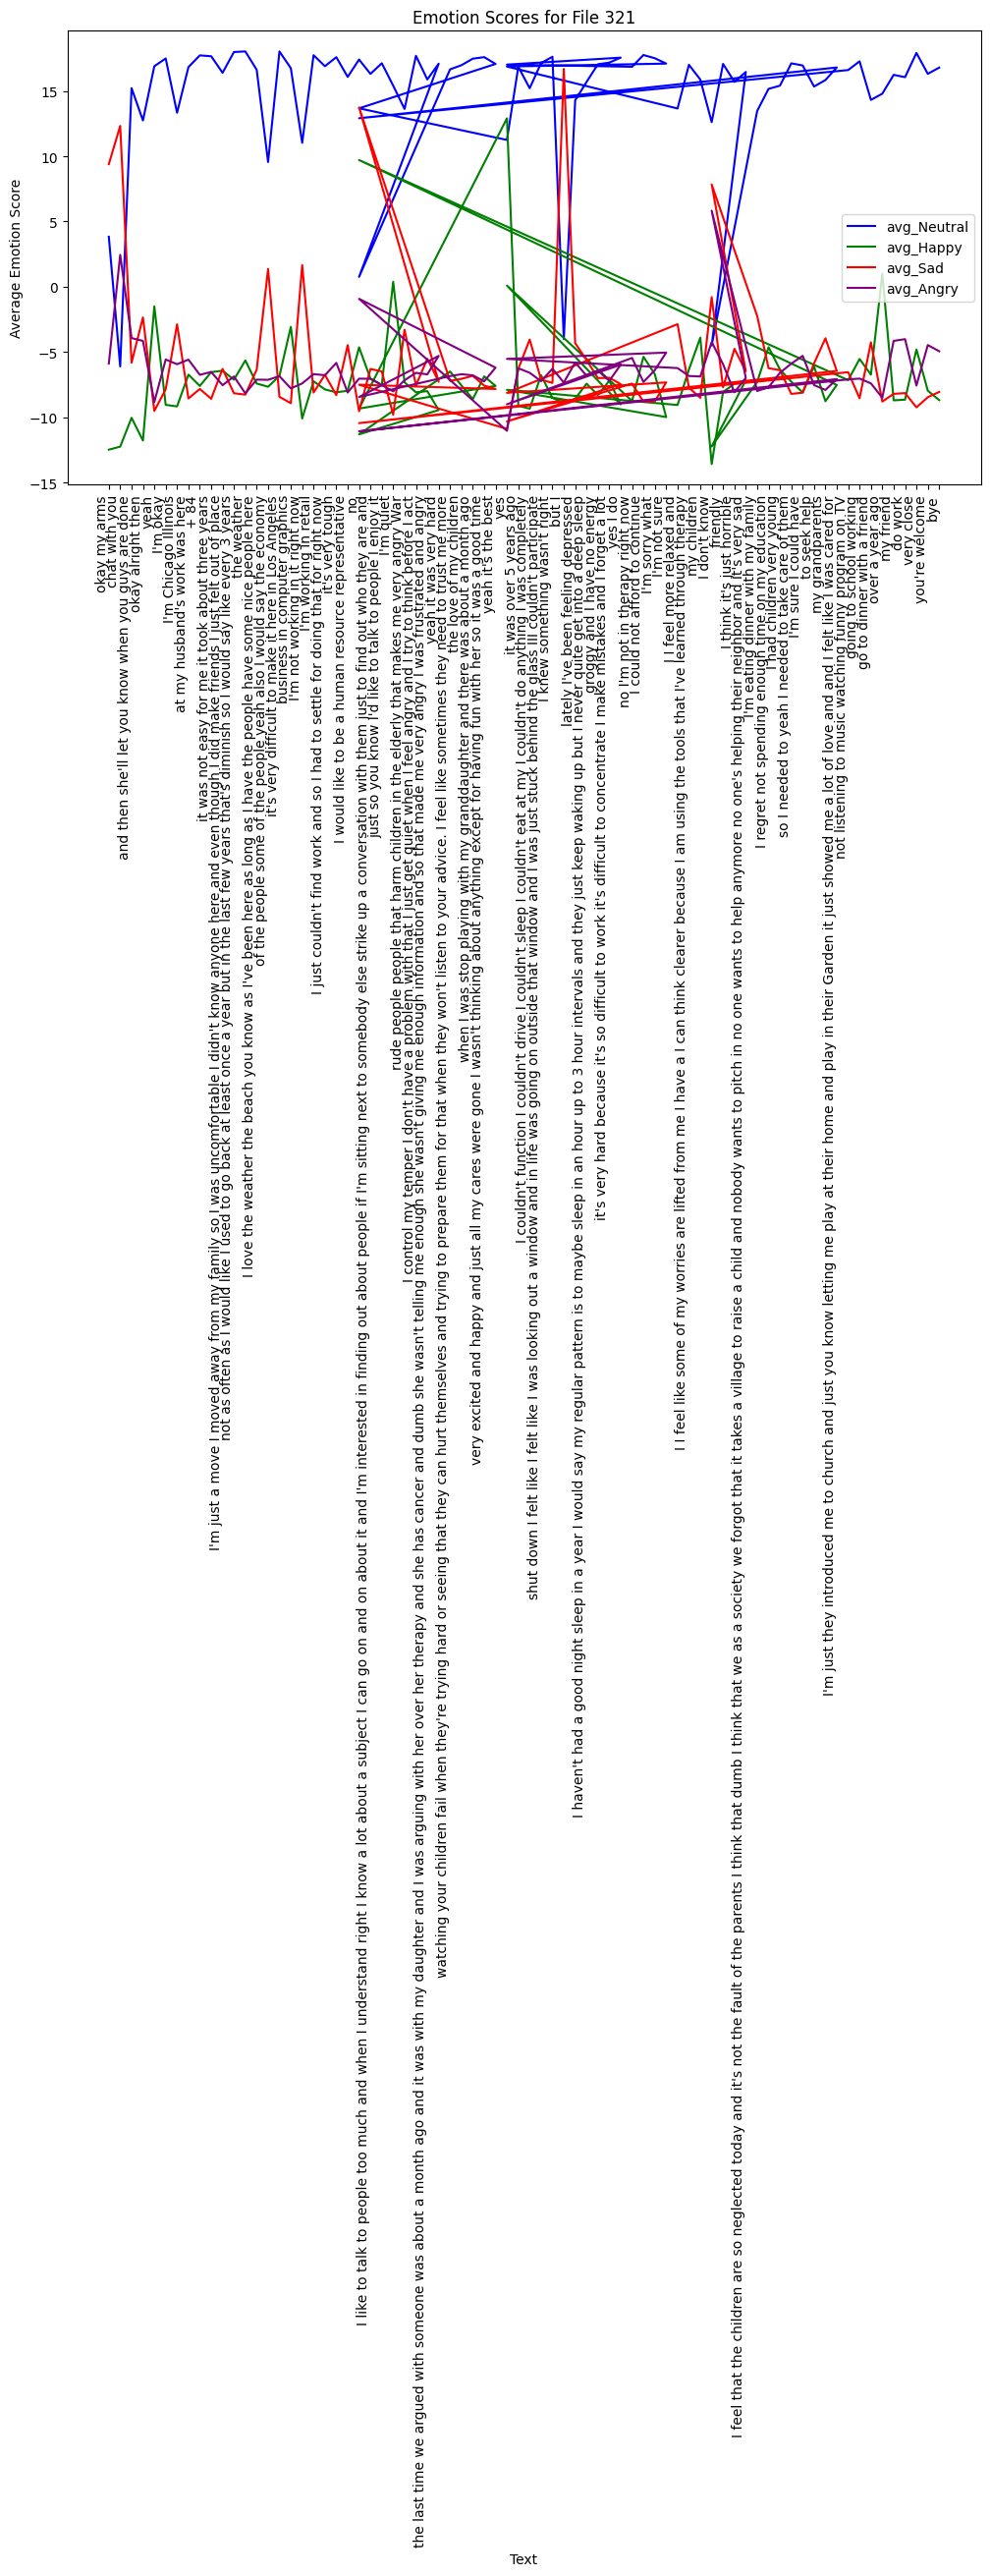

In [74]:
# prompt: line plot df_321 by xlabel is 'Text' and ['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry'] are lines in different colours

import matplotlib.pyplot as plt

# Assuming df_321 is defined as in the provided code
# df_321 = merged_df[merged_df['File']==321][['Text','avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry']]

plt.figure(figsize=(12, 6))

emotions = ['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry']
colors = ['blue', 'green', 'red', 'purple']

for i, emotion in enumerate(emotions):
  plt.plot(df_321['Text'], df_321[emotion], label=emotion, color=colors[i])

plt.xlabel('Text')
plt.ylabel('Average Emotion Score')
plt.title('Emotion Scores for File 321')
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# df_target = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/metadata_mapped.csv')
# df_target

Participant_ID AVECParticipant_ID  Gender  PHQ_Binary  PHQ_Score  \
0               302       training_001    male           0          4   
1               303       training_002  female           0          0   
2               304       training_003  female           0          6   
3               305       training_004    male           0          7   
4               307       training_005  female           0          4   
..              ...                ...     ...         ...        ...   
214             667     development_52    male           0          3   
215             670     development_53    male           0          0   
216             687     development_54    male           0          7   
217             698     development_55    male           1         19   
218             713     development_56    male           0          0   

     PCL-C (PTSD)  PTSD Severity  
0               0             28  
1               0             17  
2               0             20  
3               0             28  
4               0             23  
..            ...            ...  
214             0             23  
215             0             21  
216             1             44  
217             1             60  
218             0             22  

[219 rows x 7 columns]

In [ ]:
# prompt: Create new dataframe that have all from df_target and average all pred scores by File and add them to df_target where df_target['Participant_ID'] equals to merged_df['Flie']

# Create a list of prediction columns
pred_cols = [col for col in merged_df.columns if '_pred' in col]

# Group by 'File' and calculate the average of prediction columns
merged_grouped = merged_df.groupby('File')[pred_cols].mean().reset_index()

# Merge the grouped data with df_target
df_final = pd.merge(df_target, merged_grouped, left_on='Participant_ID', right_on='File', how='left')

# Print the head of the final dataframe
print(df_final.head())

# Save the final dataframe to a CSV file (optional)
df_final.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/final_dataframe.csv', index=False)

   Participant_ID AVECParticipant_ID  Gender  PHQ_Binary  PHQ_Score  \
0             302       training_001    male           0          4   
1             303       training_002  female           0          0   
2             304       training_003  female           0          6   
3             305       training_004    male           0          7   
4             307       training_005  female           0          4   

   PCL-C (PTSD)  PTSD Severity   File  Decision Tree Regressor_pred  \
0             0             28  302.0                      4.000000   
1             0             17    NaN                           NaN   
2             0             20  304.0                      6.006885   
3             0             28  305.0                      6.998188   
4             0             23    NaN                           NaN   

   Random Forest Regressor_pred  Decision Tree Classifier_pred  \
0                      4.002156                       3.999382   
1             

In [ ]:
# prompt: count rows in df_final separate by  value in AVECParticipant_ID  that starts with 'training_' and 'development_'

# Count rows where 'AVECParticipant_ID' starts with 'training_'
training_count = df_final[df_final['AVECParticipant_ID'].str.startswith('training_')].shape[0]

# Count rows where 'AVECParticipant_ID' starts with 'development_'
development_count = df_final[df_final['AVECParticipant_ID'].str.startswith('development_')].shape[0]

print(f"Number of rows with AVECParticipant_ID starting with 'training_': {training_count}")
print(f"Number of rows with AVECParticipant_ID starting with 'development_': {development_count}")

Number of rows with AVECParticipant_ID starting with 'training_': 163
Number of rows with AVECParticipant_ID starting with 'development_': 56


In [ ]:
# prompt: Create new dataframe that remove all NaN rows in df_final

df_final_cleaned = df_final.dropna()
print(df_final_cleaned.head())
# Save the cleaned dataframe to a CSV file (optional)
df_final_cleaned.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/final_dataframe_noNaN.csv', index=False)

   Participant_ID AVECParticipant_ID  Gender  PHQ_Binary  PHQ_Score  \
0             302       training_001    male           0          4   
2             304       training_003  female           0          6   
3             305       training_004    male           0          7   
5             308       training_006  female           1         22   
6             309       training_007    male           1         15   

   PCL-C (PTSD)  PTSD Severity   File  Decision Tree Regressor_pred  \
0             0             28  302.0                      4.000000   
2             0             20  304.0                      6.006885   
3             0             28  305.0                      6.998188   
5             1             67  308.0                     21.983244   
6             1             74  309.0                     14.987314   

   Random Forest Regressor_pred  Decision Tree Classifier_pred  \
0                      4.002156                       3.999382   
2             

In [ ]:
# prompt: Find RMSE between PHQ_Score   and all pred columns

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming 'merged_df' and 'pred_cols' are already defined as in the previous code
# ... (previous code) ...

# Calculate RMSE for each prediction column
for col in pred_cols:
    rmse = np.sqrt(mean_squared_error(df_final_cleaned['PHQ_Score'], df_final_cleaned[col]))
    print(f"RMSE for {col}: {rmse:.4f}")

RMSE for Decision Tree Regressor_pred: 0.0118
RMSE for Random Forest Regressor_pred: 0.0200
RMSE for Decision Tree Classifier_pred: 0.0110
RMSE for Random Forest Classifier_pred: 0.0003


In [ ]:
# prompt: Separate df_final_cleaned into 'training_' and 'development_' by considering value in AVECParticipant_ID that starts with  'training_' and 'development_'. Then compute RMSE for training and development sets.

# The printed are results from frame-based emotion without emo transition
# Separate Development set (46) from all (46 + 140)
# Split the data into training and development sets
training_df = df_final_cleaned[df_final_cleaned['AVECParticipant_ID'].str.startswith('training_')]
development_df = df_final_cleaned[df_final_cleaned['AVECParticipant_ID'].str.startswith('development_')]

# Calculate RMSE for each prediction column in the training set
print(training_df.shape)
print("RMSE for training set:")
for col in pred_cols:
    rmse = np.sqrt(mean_squared_error(training_df['PHQ_Score'], training_df[col]))
    print(f"RMSE for {col}: {rmse:.4f}")

# Calculate RMSE for each prediction column in the development set
print("\n",development_df.shape)
print("RMSE for development set:")
for col in pred_cols:
    rmse = np.sqrt(mean_squared_error(development_df['PHQ_Score'], development_df[col]))
    print(f"RMSE for {col}: {rmse:.4f}")

(140, 12)
RMSE for training set:
RMSE for Decision Tree Regressor_pred: 0.0120
RMSE for Random Forest Regressor_pred: 0.0197
RMSE for Decision Tree Classifier_pred: 0.0116
RMSE for Random Forest Classifier_pred: 0.0003

 (46, 12)
RMSE for development set:
RMSE for Decision Tree Regressor_pred: 0.0110
RMSE for Random Forest Regressor_pred: 0.0208
RMSE for Decision Tree Classifier_pred: 0.0086
RMSE for Random Forest Classifier_pred: 0.0000


In [ ]:
development_df.isna().sum()

Participant_ID                             0
AVECParticipant_ID                         0
Gender                                     0
PHQ_Binary                                 0
PHQ_Score                                  0
PCL-C (PTSD)                               0
PTSD Severity                              0
File                                      10
Decision Tree Regressor_pred              10
Random Forest Regressor_pred              10
Decision Tree Classifier_pred             10
Random Forest Classifier_pred             10
Decision Tree Regressor_pred_abs_diff     10
Random Forest Regressor_pred_abs_diff     10
Decision Tree Classifier_pred_abs_diff    10
Random Forest Classifier_pred_abs_diff    10
dtype: int64

In [ ]:
development_df.describe()

Participant_ID  PHQ_Binary  PHQ_Score  PCL-C (PTSD)  PTSD Severity  \
count       56.000000   56.000000  56.000000     56.000000      56.000000   
mean       446.803571    0.214286   6.589286      0.303571      34.553571   
std        114.256875    0.414039   5.713705      0.463961      15.416543   
min        300.000000    0.000000   0.000000      0.000000      17.000000   
25%        369.500000    0.000000   2.000000      0.000000      21.750000   
50%        428.000000    0.000000   6.000000      0.000000      28.500000   
75%        476.000000    0.000000  10.250000      1.000000      46.750000   
max        713.000000    1.000000  20.000000      1.000000      72.000000   

             File  Decision Tree Regressor_pred  Random Forest Regressor_pred  \
count   46.000000                     46.000000                     46.000000   
mean   400.000000                      6.955707                      6.956189   
std     56.734469                      5.592310                      5.581663   
min    300.000000                      0.002307                      0.013438   
25%    347.750000                      2.009065                      2.016036   
50%    405.000000                      6.499549                      6.501596   
75%    446.500000                     10.742051                     10.736753   
max    486.000000                     19.991633                     19.965178   

       Decision Tree Classifier_pred  Random Forest Classifier_pred  \
count                      46.000000                      46.000000   
mean                        6.955983                       6.956526   
std                         5.594422                       5.601411   
min                         0.000000                       0.000000   
25%                         2.005649                       2.000000   
50%                         6.498844                       6.500000   
75%                        10.743399                      10.750000   
max                        19.976327                      20.000000   

       Decision Tree Regressor_pred_abs_diff  \
count                              46.000000   
mean                                0.011624   
std                                 0.006795   
min                                 0.001260   
25%                                 0.007183   
50%                                 0.010938   
75%                                 0.013611   
max                                 0.032495   

       Random Forest Regressor_pred_abs_diff  \
count                              46.000000   
mean                                0.020337   
std                                 0.010899   
min                                 0.005959   
25%                                 0.013454   
50%                                 0.016519   
75%                                 0.022762   
max                                 0.052609   

       Decision Tree Classifier_pred_abs_diff  \
count                               46.000000   
mean                                 0.008786   
std                                  0.006378   
min                                  0.000000   
25%                                  0.004406   
50%                                  0.007028   
75%                                  0.011740   
max                                  0.026550   

       Random Forest Classifier_pred_abs_diff  
count                               46.000000  
mean                                 0.000004  
std                                  0.000027  
min                                  0.000000  
25%                                  0.000000  
50%                                  0.000000  
75%                                  0.000000  
max                                  0.000184

In [ ]:
len(merged_df['File'].tolist())

934149

In [ ]:
# prompt: Use all sklearn classifiers to predict Y_PHQ_emoWprosody_seq from X_PHQ_emoWprosody_seq including classification_report
# This consider them as classification problem
# First attempt in tree-based classifier (0.8 vs 0.2) not 5-fold yet

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_PHQ_emoWprosody_seq, Y_PHQ_emoWprosody_seq, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    # "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis()
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"Classification Report for {name}:")
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"Error training {name}: {e}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.19      0.77      0.31     17379
           1       0.21      0.14      0.17     10711
           2       0.00      0.00      0.00      7290
           3       0.21      0.14      0.17     11799
           4       0.37      0.10      0.15      4919
           5       0.00      0.00      0.00      1697
           6       0.00      0.00      0.00      4105
           7       0.19      0.01      0.02      4204
           8       0.00      0.00      0.00      2253
           9       0.08      0.04      0.06      4599
          10       0.09      0.00      0.00      5412
          12       0.10      0.04      0.06      4391
          15       0.00      0.00      0.00      1766
          16       0.39      0.02      0.04      1233
          17       0.00      0.00      0.00      4104
          18       0.00      0.00      0.00      1925
          19       0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Quadratic Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.39      0.11      0.18     17379
           1       0.30      0.11      0.16     10711
           2       0.29      0.19      0.23      7290
           3       0.30      0.03      0.06     11799
           4       0.49      0.12      0.19      4919
           5       0.14      0.63      0.22      1697
           6       0.18      0.17      0.18      4105
           7       0.22      0.09      0.13      4204
           8       0.15      0.41      0.22      2253
           9       0.16      0.65      0.26      4599
          10       0.14      0.33      0.20      5412
          12       0.28      0.11      0.16      4391
          15       0.28      0.11      0.15      1766
          16       0.32      0.36      0.33      1233
          17       0.14      0.55      0.22      4104
          18       0.04      0.01      0.01      1925
          19       0.2

## Depression Detecion w prosodic features

In [ ]:
import pandas as pd
merged__emo_prosodic_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/01_Merged_emo_prosodic_df.csv', sep='\t', index_col=False)


In [ ]:
merged__emo_prosodic_df.shape

(934149, 21)

In [ ]:
# prompt: convert a string of "[[11.481985092163086, -12.933919906616211, -4.126014709472656, 0.39441609382629395], [11.079808235168457, -13.382884979248047, -3.5357425212860107, 0.470511794090271], [11.35688591003418, -13.248217582702637, -4.245136260986328, 0.7214699983596802]]" to 2d array of 4 numbers each

import ast

def string_to_2d_array(input_string):
  """Converts a string representation of a 2D array to a 2D array.

  Args:
    input_string: The string representation of the 2D array.

  Returns:
    A 2D array, or None if the input string is invalid.
  """
  try:

    array_2d = ast.literal_eval(input_string)
    return array_2d
  except (SyntaxError, ValueError):
    print("Invalid input string. Could not convert to 2D array.")
    return None

# Example usage with your string
# string_representation = "[[11.481985092163086, -12.933919906616211, -4.126014709472656, 0.39441609382629395], [11.079808235168457, -13.382884979248047, -3.5357425212860107, 0.470511794090271], [11.35688591003418, -13.248217582702637, -4.245136260986328, 0.7214699983596802]]"
# result_array = string_to_2d_array(tmptxt)
# result_array


In [ ]:
# prompt: Apply string_to_2d_array on Emotion, called them as Emotion_num

merged__emo_prosodic_df['Emotion_num'] = merged__emo_prosodic_df['Emotion'].apply(string_to_2d_array)
merged__emo_prosodic_df['File'] = merged__emo_prosodic_df['File'].astype(int)
merged__emo_prosodic_df

In [ ]:
merged__emo_prosodic_df[['File', 'Emotion_num', 'Mean Pitch (Hz)', 'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)']]

File                                        Emotion_num  \
0        405  [14.18704605102539, -9.37901782989502, -3.0459...   
1        405  [14.284719467163086, -9.366886138916016, -3.17...   
2        405  [14.304205894470215, -9.403837203979492, -3.06...   
3        405  [14.288374900817871, -9.38368034362793, -2.933...   
4        405  [14.171076774597168, -9.548325538635254, -2.76...   
...      ...                                                ...   
934144   403  [12.172088623046875, -5.947987079620361, 0.413...   
934145   403  [12.435181617736816, -5.97904634475708, 0.0719...   
934146   403  [11.873584747314453, -5.3879714012146, 0.35943...   
934147   403  [11.473380088806152, -6.333144664764404, 1.363...   
934148   403  [11.206433296203613, -6.430211544036865, 1.755...   

        Mean Pitch (Hz)  Pitch SD (Hz)  Mean Intensity (dB)  \
0            195.833283      27.956319            37.495166   
1            195.833283      27.956319            37.495166   
2            195.833283      27.956319            37.495166   
3            195.833283      27.956319            37.495166   
4            195.833283      27.956319            37.495166   
...                 ...            ...                  ...   
934144       191.891676      49.355138            44.139685   
934145       191.891676      49.355138            44.139685   
934146       191.891676      49.355138            44.139685   
934147       191.891676      49.355138            44.139685   
934148       191.891676      49.355138            44.139685   

        Intensity SD (dB)  Jitter (local) (%)  Shimmer (local) (%)   HNR (dB)  \
0               10.447007            0.017625             0.075467  17.328332   
1               10.447007            0.017625             0.075467  17.328332   
2               10.447007            0.017625             0.075467  17.328332   
3               10.447007            0.017625             0.075467  17.328332   
4               10.447007            0.017625             0.075467  17.328332   
...                   ...                 ...                  ...        ...   
934144          11.585041            0.036413             0.074211  10.433652   
934145          11.585041            0.036413             0.074211  10.433652   
934146          11.585041            0.036413             0.074211  10.433652   
934147          11.585041            0.036413             0.074211  10.433652   
934148          11.585041            0.036413             0.074211  10.433652   

        Duration (s)  
0                3.8  
1                3.8  
2                3.8  
3                3.8  
4                3.8  
...              ...  
934144           1.2  
934145           1.2  
934146           1.2  
934147           1.2  
934148           1.2  

[934149 rows x 10 columns]

In [ ]:
tmp = merged__emo_prosodic_df.iloc[:3]
tmp

File                                               Text  \
0   405  essential let you know and then you can let me...   
1   405                                             thanks   
2   405  go ahead and move his cord behind you didn't g...   

                                             Emotion  avg_Neutral  avg_Happy  \
0  [[14.18704605102539, -9.37901782989502, -3.045...    14.325210  -9.403361   
1  [[16.3295955657959, -8.033401489257812, -7.942...    16.111670  -7.742381   
2  [[15.299209594726562, -6.708323001861572, -7.8...    15.490749  -6.789825   

    avg_Sad  avg_Angry  Interval Number  Interval Start (s)  Interval End (s)  \
0 -3.037173  -6.728367                1                18.5              22.3   
1 -7.976411  -4.962175                2                23.7              24.4   
2 -8.094583  -4.434079                3                26.8              29.9   

   ...  PTSD Severity  avg_Neutral_pre_diff  avg_Happy_pre_diff  \
0  ...           50.0              0.000000            0.000000   
1  ...           50.0              1.786460            1.660979   
2  ...           50.0             -0.620921            0.952557   

   avg_Sad_pre_diff  avg_Angry_pre_diff  avg_Neutral_post_diff  \
0          0.000000            0.000000               1.786460   
1         -4.939238            1.766192              -0.620921   
2         -0.118172            0.528096              -6.182177   

   avg_Happy_post_diff  avg_Sad_post_diff  avg_Angry_post_diff  \
0             1.660979          -4.939238             1.766192   
1             0.952557          -0.118172             0.528096   
2             2.534596           9.702652            -6.188045   

                                         Emotion_num  
0  [[14.18704605102539, -9.37901782989502, -3.045...  
1  [[16.3295955657959, -8.033401489257812, -7.942...  
2  [[15.299209594726562, -6.708323001861572, -7.8...  

[3 rows x 31 columns]

In [ ]:
# 'Mean Pitch (Hz)', 'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)',

import pandas as pd

consecutive_emotions_df = pd.DataFrame(columns=['File', 'Emotion_num_sequence', 'Mean Pitch (Hz)', 'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)'])

for file_name in merged__emo_prosodic_df['File'].unique():
  file_df = merged__emo_prosodic_df[merged__emo_prosodic_df['File'] == file_name]
  emotion_nums = []
  for index, row in file_df.iterrows():
      if isinstance(row['Emotion_num'], list):  # Check if Emotion_num is a valid list
          emotion_nums.extend(row['Emotion_num'])
  emoNprosody = dict(row[10:18])
  emoNprosody['File'] = [str(int(file_name))]
  emoNprosody['Emotion_num_sequence'] = [emotion_nums]
  consecutive_emotions_df = pd.concat([consecutive_emotions_df, pd.DataFrame(emoNprosody)], ignore_index=True)
consecutive_emotions_df


<ipython-input-64-bc0748e2329e>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  consecutive_emotions_df = pd.concat([consecutive_emotions_df, pd.DataFrame(emoNprosody)], ignore_index=True)


File                               Emotion_num_sequence  Mean Pitch (Hz)  \
0    405  [[14.18704605102539, -9.37901782989502, -3.045...       202.205553   
1    406  [[5.072873115539551, -8.451581001281738, 4.147...       213.706261   
2    404  [[-1.568274736404419, -10.45511531829834, 14.2...       104.961761   
3    411  [[12.083499908447266, -7.224344253540039, -0.8...       202.723845   
4    408  [[11.924208641052246, -8.11149787902832, -4.18...       196.679228   
..   ...                                                ...              ...   
187  399  [[12.10141658782959, -0.9339239597320557, -7.5...       177.859005   
188  402  [[16.275787353515625, -10.652584075927734, -6....       146.505779   
189  401  [[15.898780822753906, -12.476033210754395, -4....       185.957351   
190  400  [[5.234408378601074, -10.276752471923828, -5.9...       168.948798   
191  403  [[15.559688568115234, -9.567599296569824, -7.9...       191.891676   

     Pitch SD (Hz)  Mean Intensity (dB)  Intensity SD (dB)  \
0        36.579457            47.415845          12.921852   
1        42.702841            47.979924           7.208293   
2        17.856181            37.388119           9.879545   
3        42.722641            26.560682           4.107303   
4        60.206918            31.210551           7.393540   
..             ...                  ...                ...   
187      32.031124            31.383515           3.478434   
188      42.025676            40.012465           9.577424   
189      46.595963            33.218052          10.008145   
190      13.632513            26.338998           3.210123   
191      49.355138            44.139685          11.585041   

     Jitter (local) (%)  Shimmer (local) (%)   HNR (dB)  Duration (s)  
0              0.017873             0.116978  11.837990           5.9  
1              0.029452             0.138159   9.774087           2.0  
2              0.034347             0.155266   7.537243           1.6  
3              0.025953             0.205996   6.749844           4.2  
4              0.015892             0.099633   8.077966           0.6  
..                  ...                  ...        ...           ...  
187            0.020968             0.225477   6.641995           1.1  
188            0.023452             0.091445  14.259250           9.3  
189            0.028871             0.089537   8.986801           0.6  
190            0.019583             0.229980   4.864689           1.0  
191            0.036413             0.074211  10.433652           1.2  

[192 rows x 10 columns]

In [ ]:
# prompt: Create a new dataframe which contians File and  append all corresponding consecutive Emotion_num as new column

# import pandas as pd

# consecutive_emotions_df = pd.DataFrame(columns=['File', 'Emotion_num_sequence'])

# for file_name in merged__emo_prosodic_df['File'].unique():
#   file_df = merged__emo_prosodic_df[merged__emo_prosodic_df['File'] == file_name]
#   emotion_nums = []
#   for index, row in file_df.iterrows():
#       if isinstance(row['Emotion_num'], list):  # Check if Emotion_num is a valid list
#           emotion_nums.extend(row['Emotion_num'])
#   consecutive_emotions_df = pd.concat([consecutive_emotions_df, pd.DataFrame({'File': [file_name], 'Emotion_num_sequence': [emotion_nums]})], ignore_index=True)

# consecutive_emotions_df

File                               Emotion_num_sequence
0   405  [[14.18704605102539, -9.37901782989502, -3.045...
1   406  [[5.072873115539551, -8.451581001281738, 4.147...
2   404  [[-1.568274736404419, -10.45511531829834, 14.2...
3   411  [[12.083499908447266, -7.224344253540039, -0.8...
4   408  [[11.924208641052246, -8.11149787902832, -4.18...
..  ...                                                ...
93  303  [[6.868858337402344, -3.0343472957611084, 1.08...
94  301  [[13.013382911682129, -10.31943416595459, -5.3...
95  304  [[12.88292121887207, -10.2269287109375, -6.618...
96  300  [[11.481985092163086, -12.933919906616211, -4....
97  302  [[15.060911178588867, -12.142557144165039, -6....

[98 rows x 2 columns]

In [ ]:
# prompt: Create new dataframe by loop over each row in consecutive_emotions_df extract Emotion_num_sequence in to serveral rows then append them keep using same File

import pandas as pd
import ast

expanded_emotions_df = pd.DataFrame(columns=['File', 'Emotion_num', 'Mean Pitch (Hz)', 'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)'])

for index, row in merged__emo_prosodic_df.iterrows(): #merged__emo_prosodic_df
    file_name = row['File']
    emotion_sequence = row['Emotion_num']

    for emotion_num in emotion_sequence:
        emoNprosody = dict(row[10:18])
        emoNprosody['File'] = [file_name]
        emoNprosody['Emotion_num'] = [emotion_num]
        expanded_emotions_df = pd.concat([expanded_emotions_df, pd.DataFrame(emoNprosody)], ignore_index=True)
expanded_emotions_df

# Save the expanded DataFrame to your Google Drive
# expanded_emotions_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/expanded_compactEmotionsWprosody_df.csv', sep='\t', index=False)

<ipython-input-65-452b5af7983b>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  expanded_emotions_df = pd.concat([expanded_emotions_df, pd.DataFrame(emoNprosody)], ignore_index=True)


File                                        Emotion_num  \
0       405  [14.18704605102539, -9.37901782989502, -3.0459...   
1       405  [14.284719467163086, -9.366886138916016, -3.17...   
2       405  [14.304205894470215, -9.403837203979492, -3.06...   
3       405  [14.288374900817871, -9.38368034362793, -2.933...   
4       405  [14.171076774597168, -9.548325538635254, -2.76...   
...     ...                                                ...   
964034  403  [12.172088623046875, -5.947987079620361, 0.413...   
964035  403  [12.435181617736816, -5.97904634475708, 0.0719...   
964036  403  [11.873584747314453, -5.3879714012146, 0.35943...   
964037  403  [11.473380088806152, -6.333144664764404, 1.363...   
964038  403  [11.206433296203613, -6.430211544036865, 1.755...   

        Mean Pitch (Hz)  Pitch SD (Hz)  Mean Intensity (dB)  \
0            195.833283      27.956319            37.495166   
1            195.833283      27.956319            37.495166   
2            195.833283      27.956319            37.495166   
3            195.833283      27.956319            37.495166   
4            195.833283      27.956319            37.495166   
...                 ...            ...                  ...   
964034       191.891676      49.355138            44.139685   
964035       191.891676      49.355138            44.139685   
964036       191.891676      49.355138            44.139685   
964037       191.891676      49.355138            44.139685   
964038       191.891676      49.355138            44.139685   

        Intensity SD (dB)  Jitter (local) (%)  Shimmer (local) (%)   HNR (dB)  \
0               10.447007            0.017625             0.075467  17.328332   
1               10.447007            0.017625             0.075467  17.328332   
2               10.447007            0.017625             0.075467  17.328332   
3               10.447007            0.017625             0.075467  17.328332   
4               10.447007            0.017625             0.075467  17.328332   
...                   ...                 ...                  ...        ...   
964034          11.585041            0.036413             0.074211  10.433652   
964035          11.585041            0.036413             0.074211  10.433652   
964036          11.585041            0.036413             0.074211  10.433652   
964037          11.585041            0.036413             0.074211  10.433652   
964038          11.585041            0.036413             0.074211  10.433652   

        Duration (s)  
0                3.8  
1                3.8  
2                3.8  
3                3.8  
4                3.8  
...              ...  
964034           1.2  
964035           1.2  
964036           1.2  
964037           1.2  
964038           1.2  

[964039 rows x 10 columns]

In [ ]:
expanded_emotions_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/expanded_compactEmotionsWprosody_df_.csv', sep='\t', index=False)

In [ ]:
import pandas as pd
expanded_emotionsWprosody_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/expanded_compactEmotionsWprosody_df_.csv',sep='\t')
expanded_emotionsWprosody_df

File                                        Emotion_num  \
0        405  [14.18704605102539, -9.37901782989502, -3.0459...   
1        405  [14.284719467163086, -9.366886138916016, -3.17...   
2        405  [14.304205894470215, -9.403837203979492, -3.06...   
3        405  [14.288374900817871, -9.38368034362793, -2.933...   
4        405  [14.171076774597168, -9.548325538635254, -2.76...   
...      ...                                                ...   
964034   403  [12.172088623046875, -5.947987079620361, 0.413...   
964035   403  [12.435181617736816, -5.97904634475708, 0.0719...   
964036   403  [11.873584747314453, -5.3879714012146, 0.35943...   
964037   403  [11.473380088806152, -6.333144664764404, 1.363...   
964038   403  [11.206433296203613, -6.430211544036865, 1.755...   

        Mean Pitch (Hz)  Pitch SD (Hz)  Mean Intensity (dB)  \
0            195.833283      27.956319            37.495166   
1            195.833283      27.956319            37.495166   
2            195.833283      27.956319            37.495166   
3            195.833283      27.956319            37.495166   
4            195.833283      27.956319            37.495166   
...                 ...            ...                  ...   
964034       191.891676      49.355138            44.139685   
964035       191.891676      49.355138            44.139685   
964036       191.891676      49.355138            44.139685   
964037       191.891676      49.355138            44.139685   
964038       191.891676      49.355138            44.139685   

        Intensity SD (dB)  Jitter (local) (%)  Shimmer (local) (%)   HNR (dB)  \
0               10.447007            0.017625             0.075467  17.328332   
1               10.447007            0.017625             0.075467  17.328332   
2               10.447007            0.017625             0.075467  17.328332   
3               10.447007            0.017625             0.075467  17.328332   
4               10.447007            0.017625             0.075467  17.328332   
...                   ...                 ...                  ...        ...   
964034          11.585041            0.036413             0.074211  10.433652   
964035          11.585041            0.036413             0.074211  10.433652   
964036          11.585041            0.036413             0.074211  10.433652   
964037          11.585041            0.036413             0.074211  10.433652   
964038          11.585041            0.036413             0.074211  10.433652   

        Duration (s)  
0                3.8  
1                3.8  
2                3.8  
3                3.8  
4                3.8  
...              ...  
964034           1.2  
964035           1.2  
964036           1.2  
964037           1.2  
964038           1.2  

[964039 rows x 10 columns]

Index(['File', 'Emotion_num'], dtype='object')

In [ ]:
import ast
# Convert string representations of lists to actual lists before converting to float
expanded_emotionsWprosody_df['Emotion_num'] = expanded_emotionsWprosody_df['Emotion_num'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') and x.endswith(']') else x
)
expanded_emotionsWprosody_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/expanded_emotionsWprosody_df__.csv', sep='\t', index=False)

Neutral      Happy       Sad     Angry
0       14.187046  -9.379018 -3.045913 -6.609662
1       14.284719  -9.366886 -3.174044 -6.572013
2       14.304206  -9.403837 -3.065950 -6.716697
3       14.288375  -9.383680 -2.933273 -6.866247
4       14.171077  -9.548326 -2.768356 -6.757293
...           ...        ...       ...       ...
482065   4.612441 -10.283037 -6.768306  9.431493
482066   4.660172 -10.318387 -6.805552  9.370235
482067   4.589674 -10.267358 -6.703075  9.374187
482068   4.651414 -10.238569 -6.702635  9.267148
482069   4.659691 -10.248243 -6.700189  9.392010

[482070 rows x 4 columns]

In [ ]:
# prompt: Split values in Emotion_num into columns = ['Neutral','Happy','Sad','Angry']

import pandas as pd

# Assuming 'expanded_emotions_df' is already defined and populated as in your previous code
# expanded_emotions_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/expanded_emotions_df.csv', sep='\t')

# Split 'Emotion_num' into separate columns
expanded_emotionsWprosody_df[['Neutral', 'Happy', 'Sad', 'Angry']] = pd.DataFrame(expanded_emotionsWprosody_df['Emotion_num'].tolist(), index=expanded_emotionsWprosody_df.index)
# Display the updated DataFrame (optional)
print(expanded_emotionsWprosody_df.head())

# Save the updated DataFrame (optional)
expanded_emotionsWprosody_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/expanded_emotionsWprosody_df_split_.csv', sep='\t', index=False)

   File                                        Emotion_num  Mean Pitch (Hz)  \
0   405  [14.18704605102539, -9.37901782989502, -3.0459...       195.833283   
1   405  [14.284719467163086, -9.366886138916016, -3.17...       195.833283   
2   405  [14.304205894470215, -9.403837203979492, -3.06...       195.833283   
3   405  [14.288374900817871, -9.38368034362793, -2.933...       195.833283   
4   405  [14.171076774597168, -9.548325538635254, -2.76...       195.833283   

   Pitch SD (Hz)  Mean Intensity (dB)  Intensity SD (dB)  Jitter (local) (%)  \
0      27.956319            37.495166          10.447007            0.017625   
1      27.956319            37.495166          10.447007            0.017625   
2      27.956319            37.495166          10.447007            0.017625   
3      27.956319            37.495166          10.447007            0.017625   
4      27.956319            37.495166          10.447007            0.017625   

   Shimmer (local) (%)   HNR (dB)  Duration 

In [ ]:
df_target = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/metadata_mapped.csv')
df_target

Participant_ID AVECParticipant_ID  Gender  PHQ_Binary  PHQ_Score  \
0               302       training_001    male           0          4   
1               303       training_002  female           0          0   
2               304       training_003  female           0          6   
3               305       training_004    male           0          7   
4               307       training_005  female           0          4   
..              ...                ...     ...         ...        ...   
214             667     development_52    male           0          3   
215             670     development_53    male           0          0   
216             687     development_54    male           0          7   
217             698     development_55    male           1         19   
218             713     development_56    male           0          0   

     PCL-C (PTSD)  PTSD Severity  
0               0             28  
1               0             17  
2               0             20  
3               0             28  
4               0             23  
..            ...            ...  
214             0             23  
215             0             21  
216             1             44  
217             1             60  
218             0             22  

[219 rows x 7 columns]

In [ ]:
# prompt: merge expanded_emotions_df and df_target where expanded_emotions_df['File'] == df_target['Participant_ID']

# Merge the two dataframes
merged_df = pd.merge(expanded_emotionsWprosody_df, df_target, left_on='File', right_on='Participant_ID', how='inner')

# Display the merged dataframe (optional)
print(merged_df.head())

# Save the merged dataframe (optional)
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequenceWprosodyWTargetOutput_.csv', sep='\t', index=False)

   File                                        Emotion_num  Mean Pitch (Hz)  \
0   405  [14.18704605102539, -9.37901782989502, -3.0459...       195.833283   
1   405  [14.284719467163086, -9.366886138916016, -3.17...       195.833283   
2   405  [14.304205894470215, -9.403837203979492, -3.06...       195.833283   
3   405  [14.288374900817871, -9.38368034362793, -2.933...       195.833283   
4   405  [14.171076774597168, -9.548325538635254, -2.76...       195.833283   

   Pitch SD (Hz)  Mean Intensity (dB)  Intensity SD (dB)  Jitter (local) (%)  \
0      27.956319            37.495166          10.447007            0.017625   
1      27.956319            37.495166          10.447007            0.017625   
2      27.956319            37.495166          10.447007            0.017625   
3      27.956319            37.495166          10.447007            0.017625   
4      27.956319            37.495166          10.447007            0.017625   

   Shimmer (local) (%)   HNR (dB)  Duration 

In [ ]:
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequenceWprosodyWTargetOutput_.csv', sep='\t')
merged_df.shape

(934149, 21)

In [ ]:
merged_df.shape

(934149, 21)

In [ ]:
Y_emoWprosody_seq = merged_df['PHQ_Binary'].fillna(-1)
X_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])

<Figure size 1000x600 with 0 Axes>

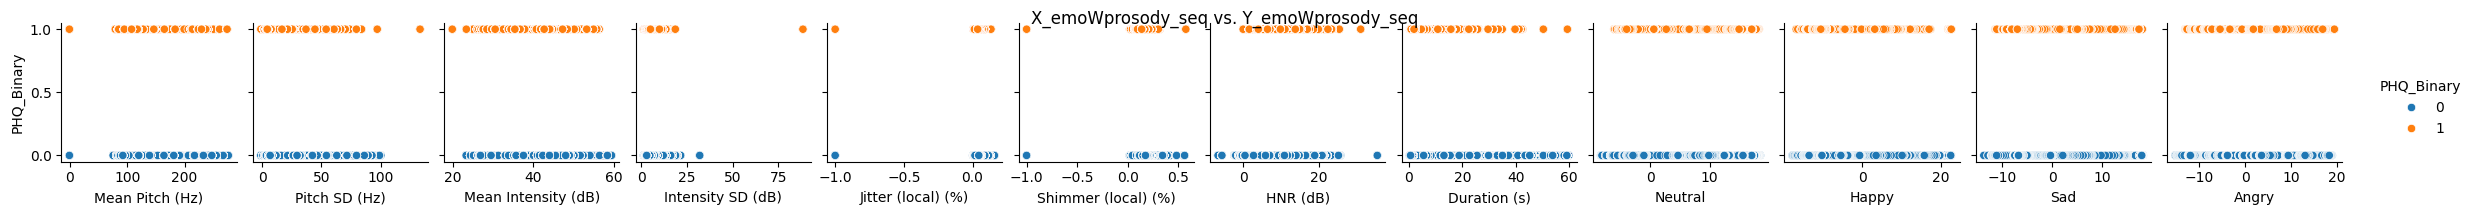

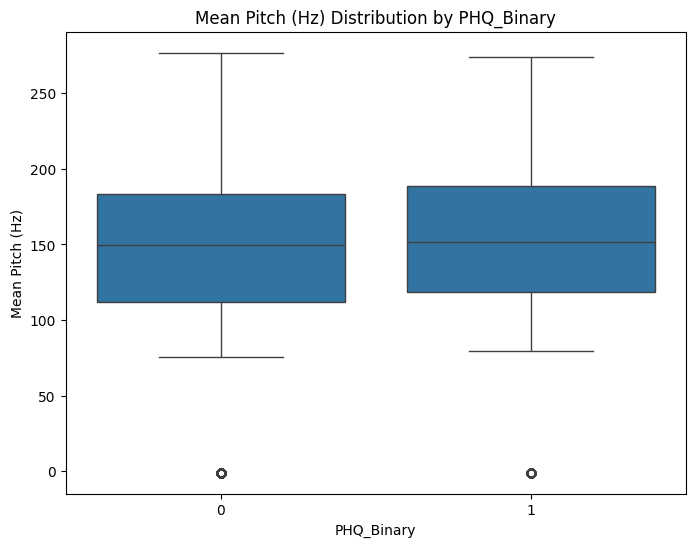

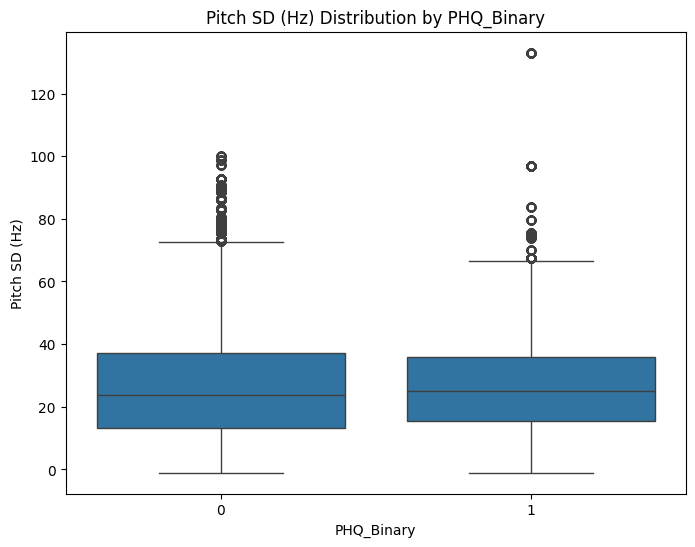

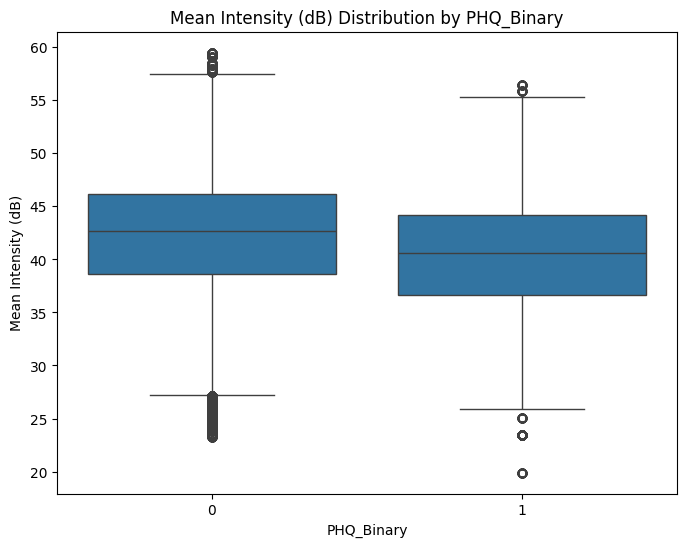

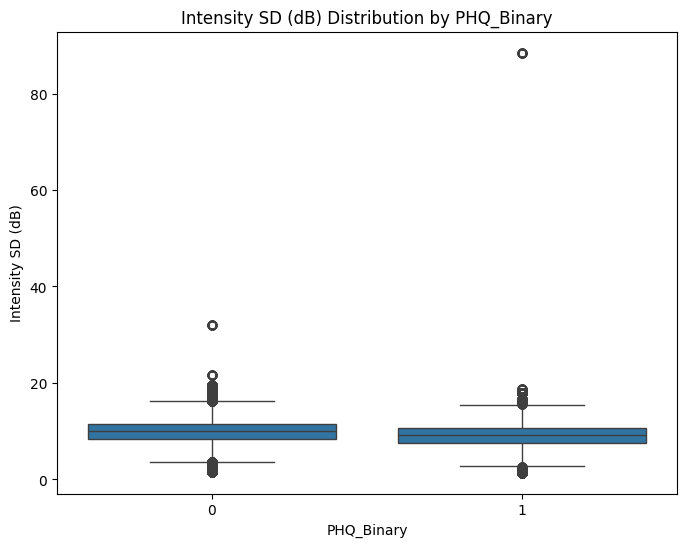

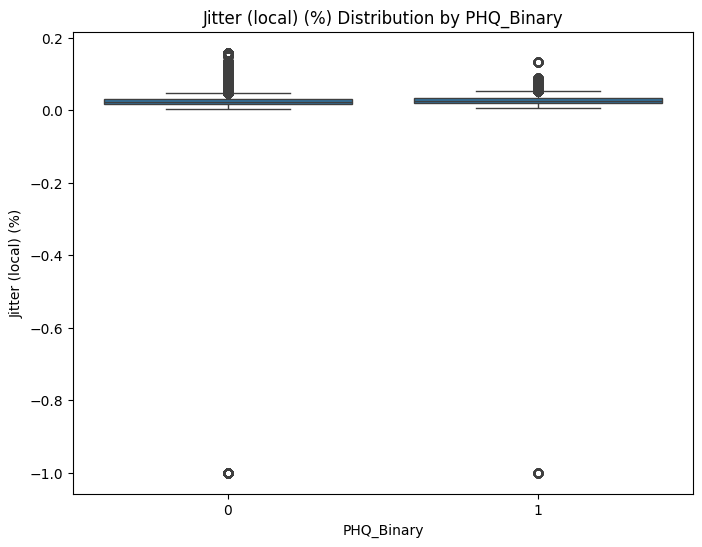

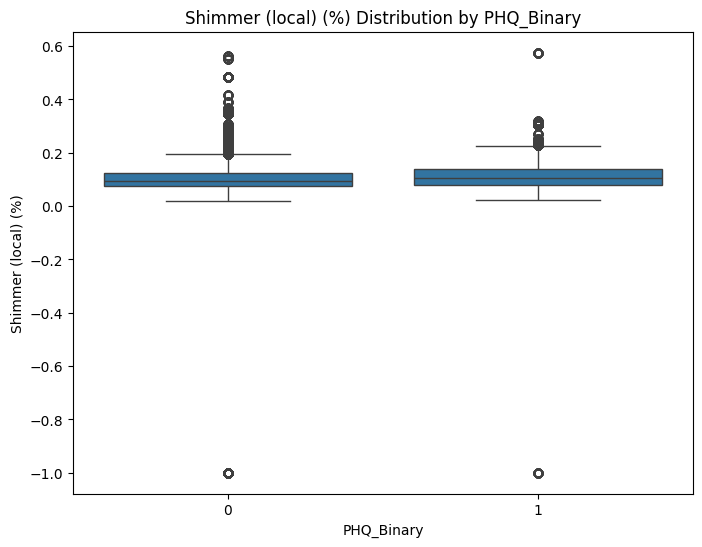

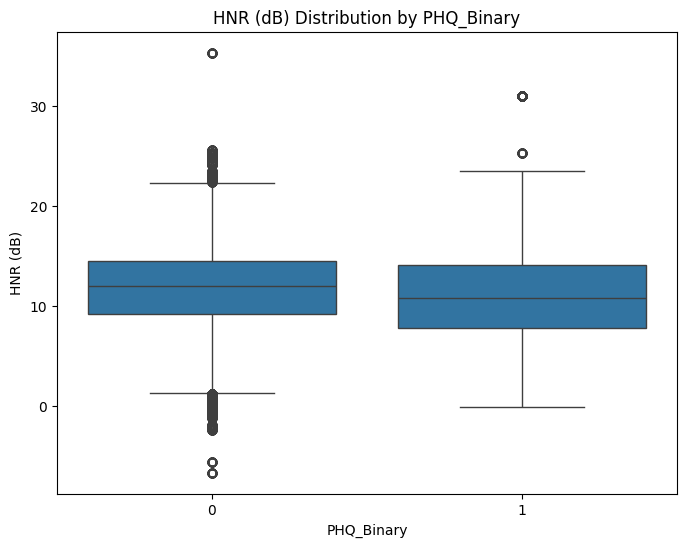

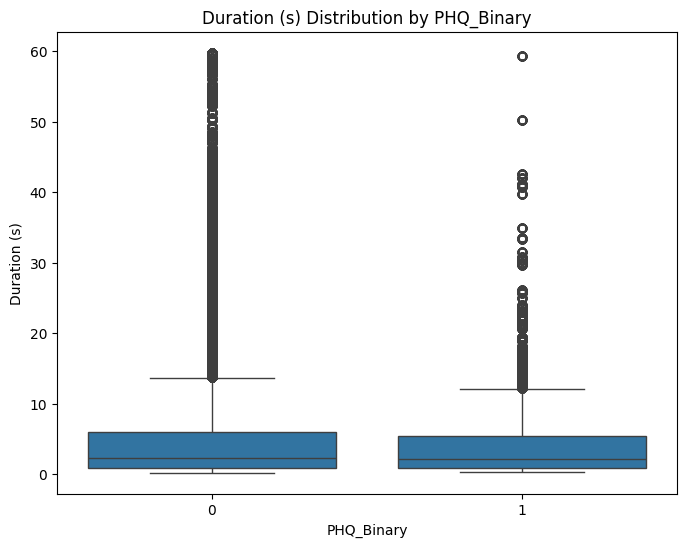

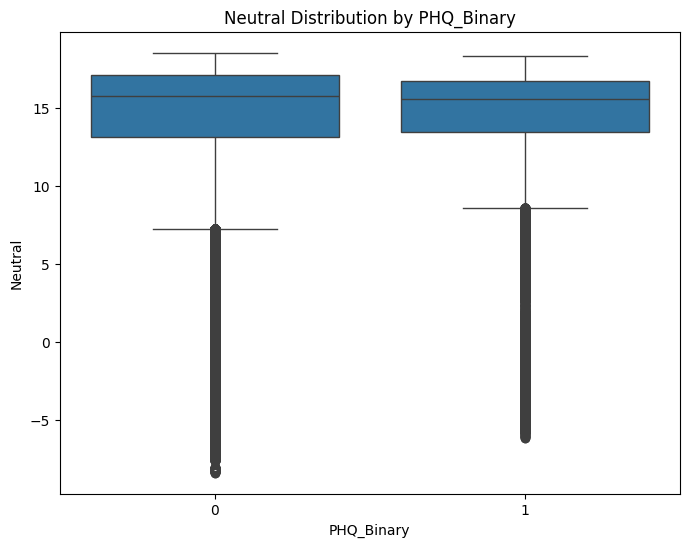

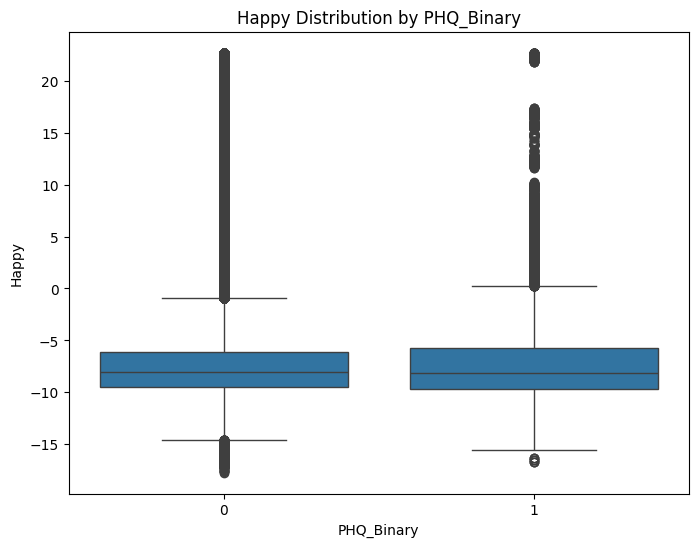

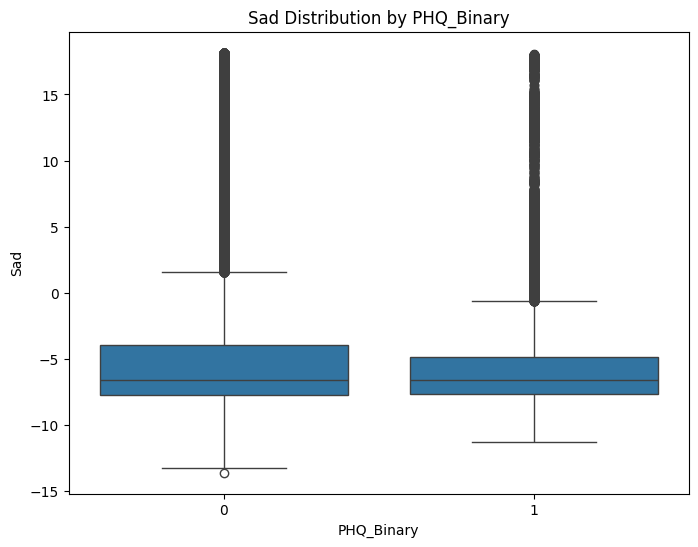

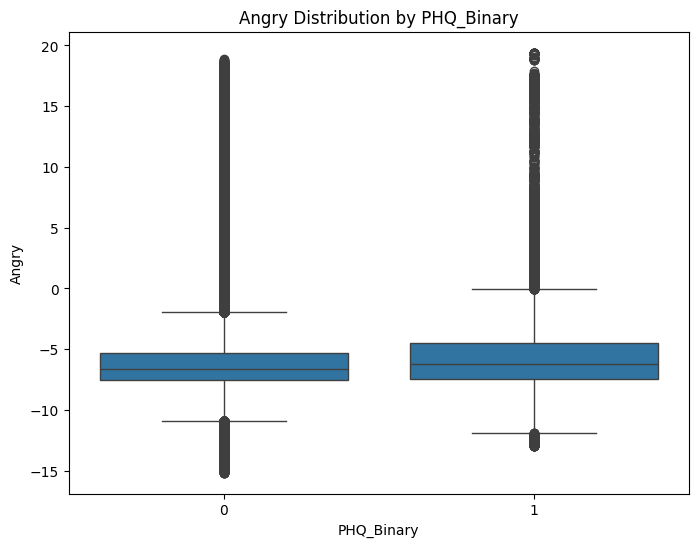

In [ ]:
# comment out to just avoid rerun coz it takes too long time
## prompt: plot X_emoWprosody_seq for each Y_emoWprosody_seq group

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming X_emoWprosody_seq and Y_emoWprosody_seq are defined as in your provided code

# # Create the plot
# plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# sns.pairplot(data=merged_df, x_vars=X_emoWprosody_seq.columns, y_vars=['PHQ_Binary'], hue='PHQ_Binary', height=2)
# plt.suptitle('X_emoWprosody_seq vs. Y_emoWprosody_seq', y=1.02)
# plt.show()


# #Alternative visualization (boxplot)
# for col in X_emoWprosody_seq.columns:
#   plt.figure(figsize=(8, 6))
#   sns.boxplot(x=Y_emoWprosody_seq, y=X_emoWprosody_seq[col])
#   plt.title(f'{col} Distribution by PHQ_Binary')
#   plt.xlabel('PHQ_Binary')
#   plt.ylabel(col)
#   plt.show()

<Axes: ylabel='Frequency'>

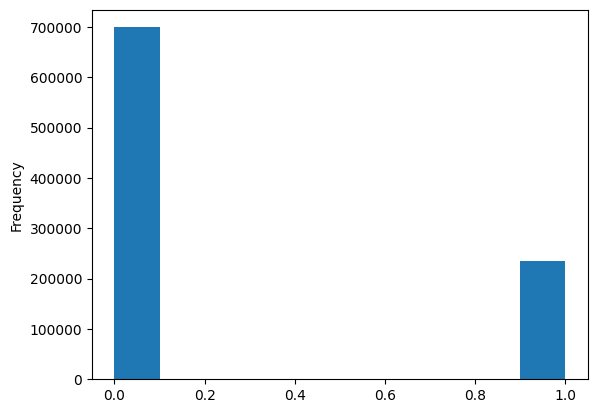

In [ ]:
Y_emoWprosody_seq.plot(kind='hist')

In [ ]:
# prompt: Use all sklearn classifiers to predict Y_emoWprosody_seq from X_emoWprosody_seq

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming X_emoWprosody_seq and Y_emoWprosody_seq are defined as in your provided code

# Handle missing values (replace -1 with the mean of the column)
for col in X_emoWprosody_seq.columns:
  X_emoWprosody_seq[col] = X_emoWprosody_seq[col].fillna(X_emoWprosody_seq[col].mean())

X_train, X_test, y_train, y_test = train_test_split(X_emoWprosody_seq, Y_emoWprosody_seq, test_size=0.2, random_state=42)


classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # "SVM": SVC(),
    # "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "AdaBoost": AdaBoostClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    # "QDA": QuadraticDiscriminantAnalysis()
}

results = {}
for name, clf in classifiers.items():
    try:
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      results[name] = accuracy
      print(f"{name}: {accuracy}")
      # Round predictions for accuracy calculation
      # y_pred_rounded = np.round(y_pred)
      # accuracy = accuracy_score(y_test, y_pred_rounded)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      mae = mean_absolute_error(y_test, y_pred)
      print(f"Accuracy: {accuracy}")
      print(f"RMSE: {rmse}")
      print(f"MAE: {mae}")

      print(classification_report(y_test, y_pred))
    except Exception as e:
      print(f"Error training {name}: {e}")
      results[name] = "Error"

results

Logistic Regression: 0.7482310121500829
Accuracy: 0.7482310121500829
RMSE: 0.5017658695546331
MAE: 0.251768987849917
              precision    recall  f1-score   support

           0       0.75      1.00      0.86    139949
           1       0.19      0.00      0.00     46881

    accuracy                           0.75    186830
   macro avg       0.47      0.50      0.43    186830
weighted avg       0.61      0.75      0.64    186830

Decision Tree: 0.9986030080822138
Accuracy: 0.9986030080822138
RMSE: 0.03737635506287662
MAE: 0.0013969919177862229
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    139949
           1       1.00      1.00      1.00     46881

    accuracy                           1.00    186830
   macro avg       1.00      1.00      1.00    186830
weighted avg       1.00      1.00      1.00    186830

Random Forest: 1.0
Accuracy: 1.0
RMSE: 0.0
MAE: 0.0
              precision    recall  f1-score   support

      

{'Logistic Regression': 0.7482310121500829,
 'Decision Tree': 0.9986030080822138,
 'Random Forest': 1.0,
 'Naive Bayes': 0.7287962318685436}

In [ ]:
# • 0-4: 0 (None)
# • 5-9: 1 (Mild)
# • 10-14: 2 (Moderate)
# • 15-19: 3 (Moderately severe)
# • 20-24: 4 (Severe)

# Create PHQ_5 column based on PHQ_Score
def categorize_phq(score):
    if 0 <= score <= 4:
        return 0
    elif 5 <= score <= 9:
        return 1
    elif 10 <= score <= 14:
        return 2
    elif 15 <= score <= 19:
        return 3
    elif 20 <= score <= 24:
        return 4
    else:
        return -1  # Handle values outside the specified range

merged_df['PHQ_5'] = merged_df['PHQ_Score'].apply(categorize_phq)

# Display the updated DataFrame (optional)
print(merged_df.head())

# Save the updated DataFrame (optional)
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequencesNProsodyWithTargetOutput_PHQ5_.csv', sep='\t', index=False)

   File                                        Emotion_num  Mean Pitch (Hz)  \
0   405  [14.18704605102539, -9.37901782989502, -3.0459...       195.833283   
1   405  [14.284719467163086, -9.366886138916016, -3.17...       195.833283   
2   405  [14.304205894470215, -9.403837203979492, -3.06...       195.833283   
3   405  [14.288374900817871, -9.38368034362793, -2.933...       195.833283   
4   405  [14.171076774597168, -9.548325538635254, -2.76...       195.833283   

   Pitch SD (Hz)  Mean Intensity (dB)  Intensity SD (dB)  Jitter (local) (%)  \
0      27.956319            37.495166          10.447007            0.017625   
1      27.956319            37.495166          10.447007            0.017625   
2      27.956319            37.495166          10.447007            0.017625   
3      27.956319            37.495166          10.447007            0.017625   
4      27.956319            37.495166          10.447007            0.017625   

   Shimmer (local) (%)   HNR (dB)  Duration 

In [ ]:
Y_emoWprosody_PHQ5_seq = merged_df['PHQ_5'].fillna(-1)
X_emoWprosody_PHQ5_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity','PHQ_5'])

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# Assuming X_emoWprosody_seq and Y_emoWprosody_seq are defined as in your provided code

# Handle missing values (replace -1 with the mean of the column)
for col in X_emoWprosody_seq.columns:
  X_emoWprosody_seq[col] = X_emoWprosody_seq[col].fillna(X_emoWprosody_seq[col].mean())

X_train, X_test, y_train, y_test = train_test_split(X_emoWprosody_PHQ5_seq, Y_emoWprosody_PHQ5_seq, test_size=0.2, random_state=42)


classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    # "SVM": SVC(),
    # "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "AdaBoost": AdaBoostClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    # "QDA": QuadraticDiscriminantAnalysis()
}

results = {}
for name, clf in classifiers.items():
    try:
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)
      results[name] = accuracy
      print(f"{name}: {accuracy}")
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      mae = mean_absolute_error(y_test, y_pred)
      print(f"Accuracy: {accuracy}")
      print(f"RMSE: {rmse}")
      print(f"MAE: {mae}")
      print(classification_report(y_test, y_pred))
    except Exception as e:
      print(f"Error training {name}: {e}")
      results[name] = "Error"

results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression: 0.39913825402772574
Accuracy: 0.39913825402772574
RMSE: 1.5992926499369575
MAE: 1.1090617138575176


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.40      0.89      0.55     73907
           1       0.35      0.13      0.19     48432
           2       0.40      0.06      0.11     34201
           3       0.00      0.00      0.00     22132
           4       0.64      0.08      0.14      8158

    accuracy                           0.40    186830
   macro avg       0.36      0.23      0.20    186830
weighted avg       0.35      0.40      0.29    186830

Decision Tree: 0.998346090028368
Accuracy: 0.998346090028368
RMSE: 0.08189402723804035
MAE: 0.002992024835411872
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     73907
           1       1.00      1.00      1.00     48432
           2       1.00      1.00      1.00     34201
           3       1.00      1.00      1.00     22132
           4       1.00      1.00      1.00      8158

    accuracy                           1.00    186830
   macro avg      

{'Logistic Regression': 0.39913825402772574,
 'Decision Tree': 0.998346090028368,
 'Random Forest': 0.9999892950810898,
 'Naive Bayes': 0.3221752395225606}

In [ ]:
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequencesNProsodyWithTargetOutput_PHQ5_.csv', sep='\t')
Y_emoWprosody_PHQ5_seq = merged_df['PHQ_5'].fillna(-1)
X_emoWprosody_PHQ5_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity','PHQ_5'])

<Figure size 1000x600 with 0 Axes>

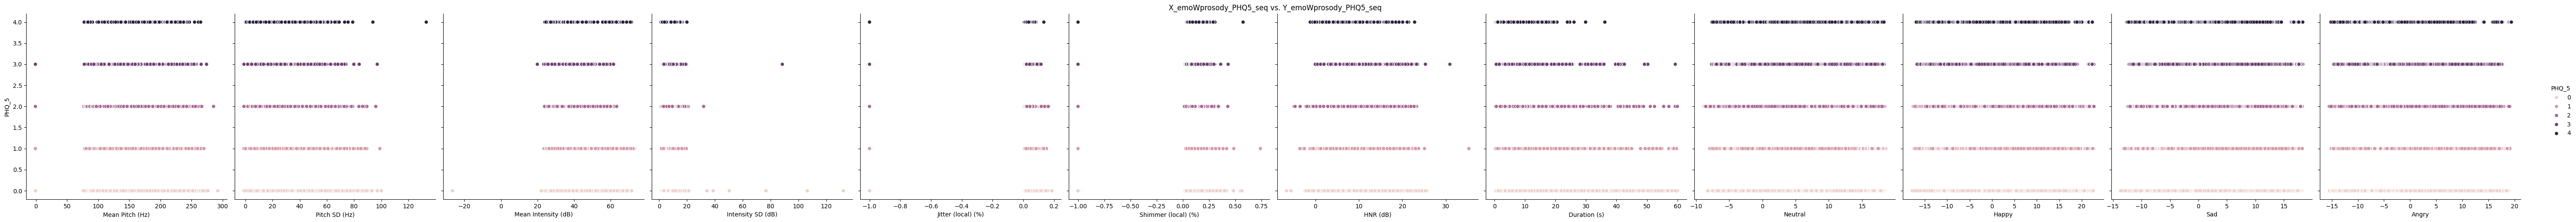

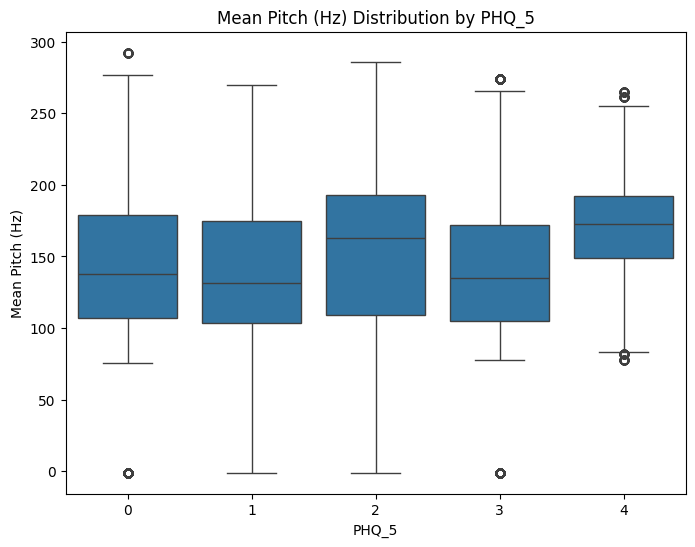

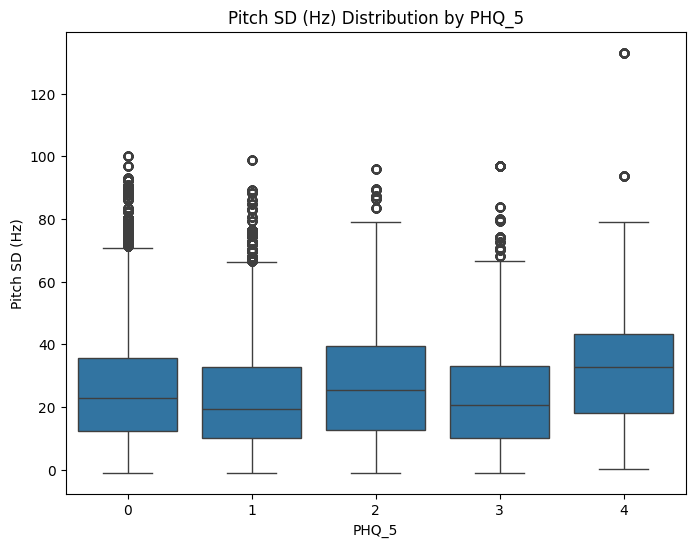

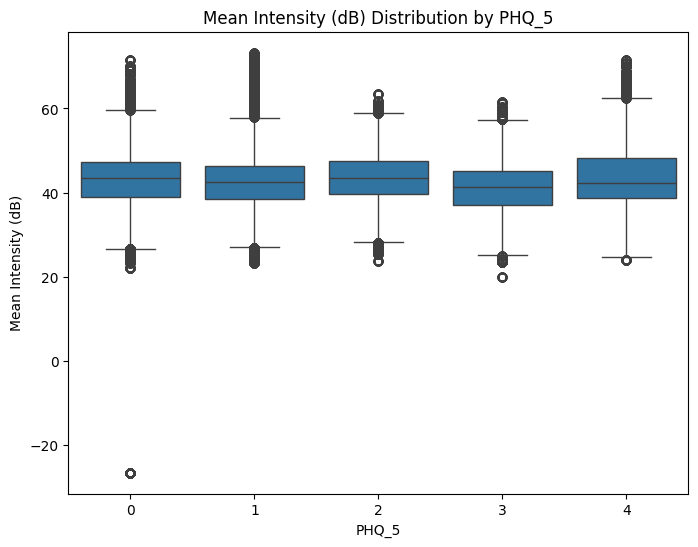

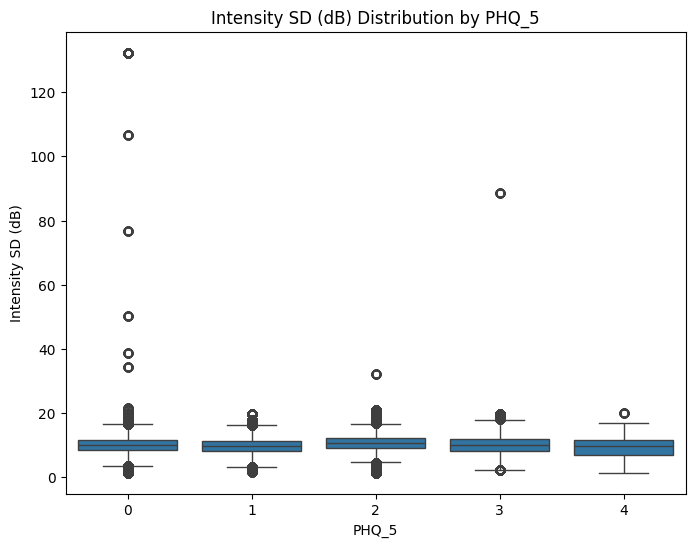

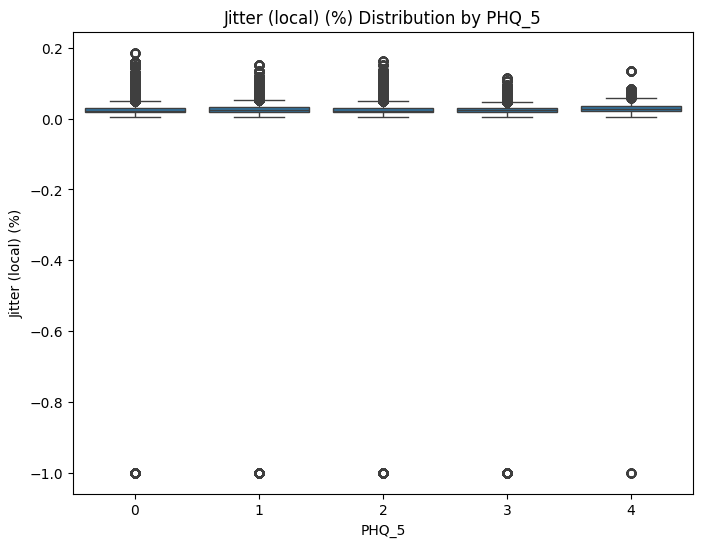

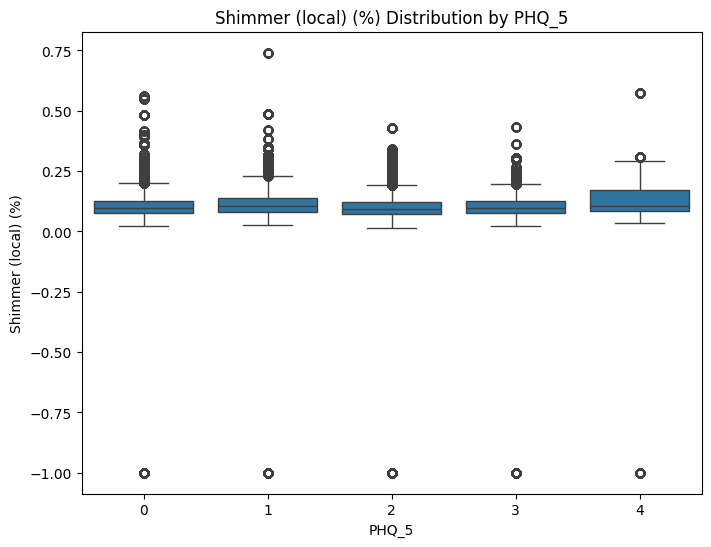

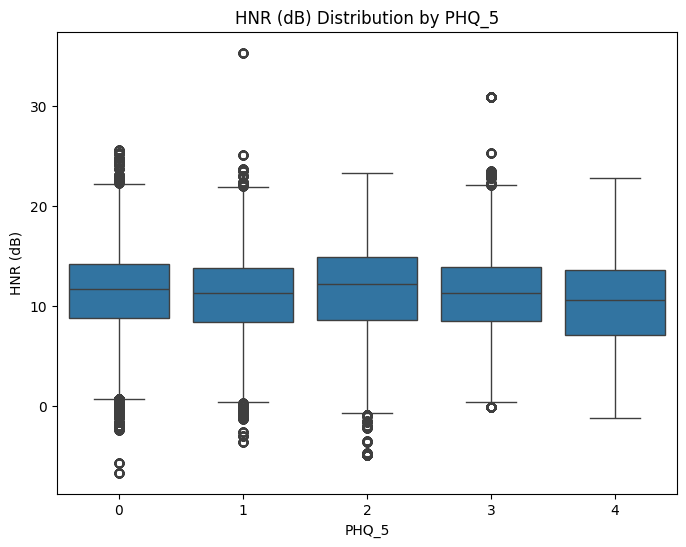

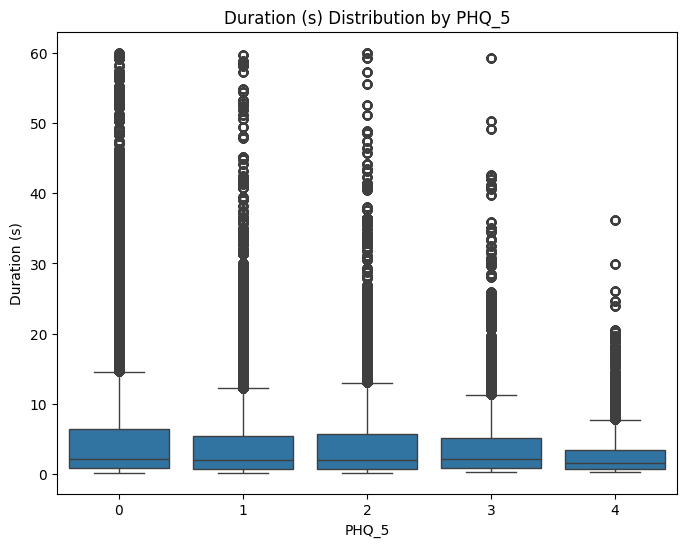

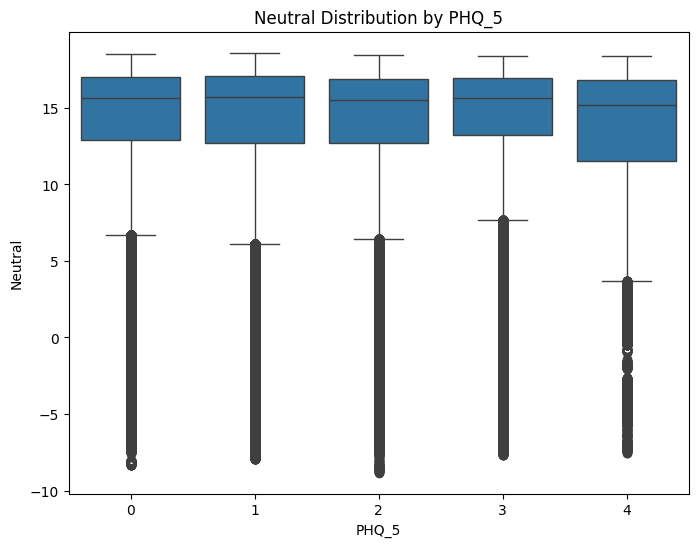

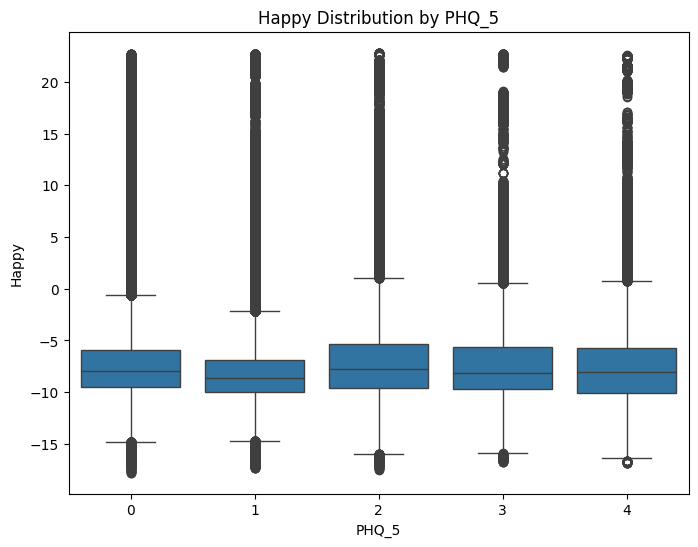

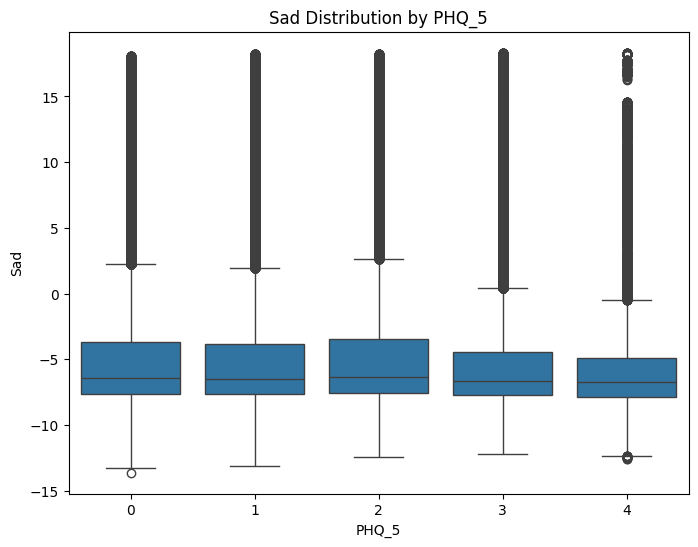

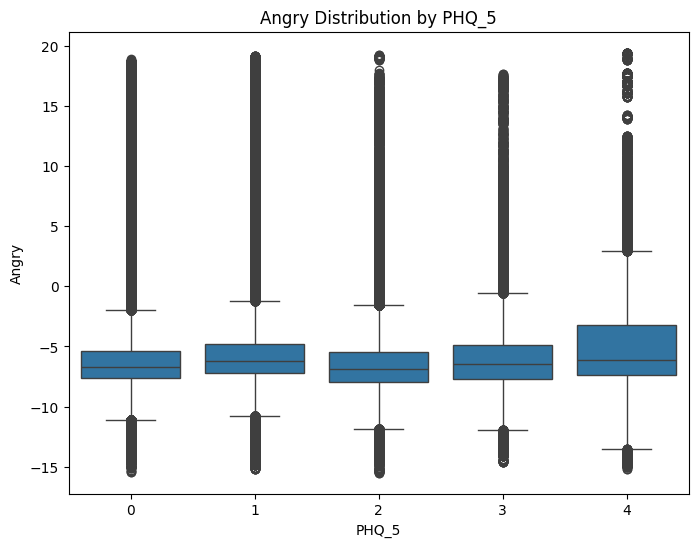

In [ ]:
# comment out to just avoid rerun coz it takes too long time
# prompt: plot X_emoWprosody_seq for each Y_emoWprosody_seq group

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_emoWprosody_seq and Y_emoWprosody_seq are defined as in your provided code

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.pairplot(data=merged_df, x_vars=X_emoWprosody_PHQ5_seq.columns, y_vars=['PHQ_5'], hue='PHQ_5', height=5)
plt.suptitle('X_emoWprosody_PHQ5_seq vs. Y_emoWprosody_PHQ5_seq', y=1.02)
plt.show()


#Alternative visualization (boxplot)
for col in X_emoWprosody_PHQ5_seq.columns:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=Y_emoWprosody_PHQ5_seq, y=X_emoWprosody_PHQ5_seq[col])
  plt.title(f'{col} Distribution by PHQ_5')
  plt.xlabel('PHQ_5')
  plt.ylabel(col)
  plt.show()

## Depression Detection without prosodic features
'''
Mean Pitch (Hz)
Pitch SD (Hz)
Mean Intensity (dB)
Intensity SD (dB)
Jitter (local) (%)
Shimmer (local) (%)
HNR (dB)
Duration (s)
'''

In [ ]:
Y_emo_seq = merged_df['PHQ_Binary'].fillna(-1)
X_emo_seq = merged_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity',
                                    'Mean Pitch (Hz)', 'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)'])

<Axes: ylabel='Frequency'>

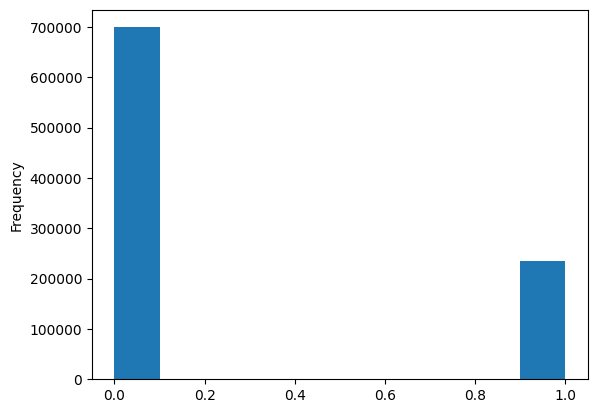

In [ ]:
Y_emo_seq.plot(kind='hist')

In [ ]:
# prompt: Use all sklearn classifier to predict Y_emo_seq from X_emo_seq

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_emo_seq, Y_emo_seq, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increased max_iter
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    # "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Classifier": MLPClassifier(max_iter=500) # Increased max_iter
}


# Train and evaluate each classifier
for name, clf in classifiers.items():
    try:
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print(f"Classification Report for {name}:")
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        mae = mean_absolute_error(Y_test, Y_pred)
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(classification_report(Y_test, Y_pred))
    except Exception as e:
        print(f"Error training {name}: {e}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression:
RMSE: 0.3193437176435357
MAE: 0.10198040999839426
              precision    recall  f1-score   support

           0       0.91      0.96      0.93    139949
           1       0.86      0.71      0.78     46881

    accuracy                           0.90    186830
   macro avg       0.88      0.83      0.86    186830
weighted avg       0.90      0.90      0.89    186830

Classification Report for Decision Tree:
RMSE: 0.019217692431799775
MAE: 0.00036931970240325427
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    139949
           1       1.00      1.00      1.00     46881

    accuracy                           1.00    186830
   macro avg       1.00      1.00      1.00    186830
weighted avg       1.00      1.00      1.00    186830

Classification Report for Random Forest:
RMSE: 0.0
MAE: 0.0
              precision    recall  f1-score   support

           0       1.00      1.00     

In [ ]:
import pandas as pd
# emo_seq_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/00_EmotionSequencesWithTargetOutput.csv', sep='\t', index_col=False)
emo_seq_df = merged_df
emo_seq_df.describe()

File  Mean Pitch (Hz)  Pitch SD (Hz)  Mean Intensity (dB)  \
count  934149.000000    934149.000000  934149.000000        934149.000000   
mean      395.699434       146.718831      25.103163            42.731378   
std        56.202836        44.976732      16.028310             7.268523   
min       300.000000        -1.000000      -1.000000           -26.548821   
25%       348.000000       106.936521      11.727317            38.754560   
50%       393.000000       141.712154      22.336378            42.950291   
75%       442.000000       182.118845      35.881921            46.871628   
max       601.000000       292.298786     133.062613            73.244628   

       Intensity SD (dB)  Jitter (local) (%)  Shimmer (local) (%)  \
count      934149.000000       934149.000000        934149.000000   
mean            9.982674            0.023958             0.106005   
std             3.679947            0.054826             0.083258   
min             1.397969           -1.000000            -1.000000   
25%             8.369565            0.018149             0.077466   
50%            10.119167            0.023296             0.098287   
75%            11.754928            0.031055             0.129802   
max           132.305460            0.186037             0.740724   

            HNR (dB)   Duration (s)        Neutral          Happy  \
count  934149.000000  934149.000000  934149.000000  934149.000000   
mean       11.348223       4.885459      13.903672      -7.183173   
std         4.228831       7.199345       4.741150       4.683670   
min        -6.634615       0.200000      -8.836839     -17.802980   
25%         8.580294       0.800000      12.818024      -9.699725   
50%        11.618927       2.100000      15.612061      -8.125259   
75%        14.208676       5.700000      16.990814      -6.040319   
max        35.333356      60.000000      18.605671      22.834545   

                 Sad          Angry  Participant_ID     PHQ_Binary  \
count  934149.000000  934149.000000   934149.000000  934149.000000   
mean       -4.811455      -5.907330      395.699434       0.251414   
std         4.806550       3.298902       56.202836       0.433826   
min       -13.632356     -15.493382      300.000000       0.000000   
25%        -7.659162      -7.597992      348.000000       0.000000   
50%        -6.471042      -6.549725      393.000000       0.000000   
75%        -3.831192      -5.105084      442.000000       1.000000   
max        18.324707      19.416897      601.000000       1.000000   

           PHQ_Score   PCL-C (PTSD)  PTSD Severity          PHQ_5  
count  934149.000000  934149.000000  934149.000000  934149.000000  
mean        7.405226       0.334290      36.760897       1.156674  
std         6.065001       0.471742      16.758716       1.191463  
min         0.000000       0.000000      17.000000       0.000000  
25%         2.000000       0.000000      22.000000       0.000000  
50%         7.000000       0.000000      31.000000       1.000000  
75%        11.000000       1.000000      50.000000       2.000000  
max        23.000000       1.000000      85.000000       4.000000

<Axes: ylabel='Frequency'>

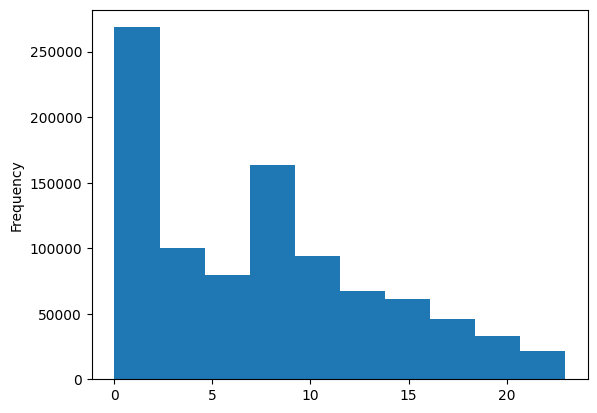

In [ ]:
Y_emo_seq = emo_seq_df['PHQ_Score'].fillna(-1)
X_emo_seq = emo_seq_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])
Y_emo_seq.plot(kind='hist')

In [ ]:
### same as above duplicated for 0-24 PHQ Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_emo_seq, Y_emo_seq, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increased max_iter
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    # "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Classifier": MLPClassifier(max_iter=500) # Increased max_iter
}


# Train and evaluate each classifier
for name, clf in classifiers.items():
    try:
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print(f"Classification Report for {name}:")
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        mae = mean_absolute_error(Y_test, Y_pred)
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(classification_report(Y_test, Y_pred))
    except Exception as e:
        print(f"Error training {name}: {e}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression:
RMSE: 2.051415856688825
MAE: 1.4005887705400633


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.33      0.87      0.48     24227
           1       0.30      0.08      0.13     15655
           2       0.38      0.12      0.18     14167
           3       0.00      0.00      0.00     12128
           4       0.22      0.05      0.08      7730
           5       0.24      0.15      0.18     10445
           6       0.36      0.01      0.01      5233
           7       0.36      0.67      0.47     16060
           8       0.42      0.10      0.16      5026
           9       0.38      0.37      0.37     11668
          10       0.39      0.72      0.50     11548
          11       0.50      0.14      0.21      7210
          12       0.44      0.45      0.44      9383
          13       0.29      0.11      0.16      4200
          14       0.57      0.07      0.12      1860
          15       0.49      0.53      0.51      5837
          16       0.39      0.45      0.42      4493
          17       0.24    

## Todo
- PHQ-5 plot distribution

In [ ]:
# prompt: Create another column from PHQ_Score called PHQ_5 to classify PHQ_Score into 5 groups:
# • 0-4: 0 (None)
# • 5-9: 1 (Mild)
# • 10-14: 2 (Moderate)
# • 15-19: 3 (Moderately severe)
# • 20-24: 4 (Severe)

# Create PHQ_5 column based on PHQ_Score
def categorize_phq(score):
    if 0 <= score <= 4:
        return 0
    elif 5 <= score <= 9:
        return 1
    elif 10 <= score <= 14:
        return 2
    elif 15 <= score <= 19:
        return 3
    elif 20 <= score <= 24:
        return 4
    else:
        return -1  # Handle values outside the specified range

emo_seq_df['PHQ_5'] = emo_seq_df['PHQ_Score'].apply(categorize_phq)

# Display the updated DataFrame (optional)
print(emo_seq_df.head())

# Save the updated DataFrame (optional) EmotionSequencesNProsodyWithTargetOutput_PHQ5_
emo_seq_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequencesWithTargetOutput_PHQ5.csv', sep='\t', index=False) #EmotionSequencesNProsodyWithTargetOutput_PHQ5_

   File                                        Emotion_num    Neutral  \
0   405  [14.18704605102539, -9.37901782989502, -3.0459...  14.187046   
1   405  [14.284719467163086, -9.366886138916016, -3.17...  14.284719   
2   405  [14.304205894470215, -9.403837203979492, -3.06...  14.304206   
3   405  [14.288374900817871, -9.38368034362793, -2.933...  14.288375   
4   405  [14.171076774597168, -9.548325538635254, -2.76...  14.171077   

      Happy       Sad     Angry  Participant_ID AVECParticipant_ID  Gender  \
0 -9.379018 -3.045913 -6.609662             405       training_080  female   
1 -9.366886 -3.174044 -6.572013             405       training_080  female   
2 -9.403837 -3.065950 -6.716697             405       training_080  female   
3 -9.383680 -2.933273 -6.866247             405       training_080  female   
4 -9.548326 -2.768356 -6.757293             405       training_080  female   

   PHQ_Binary  PHQ_Score  PCL-C (PTSD)  PTSD Severity  PHQ_5  
0           1         17     

<Axes: ylabel='Frequency'>

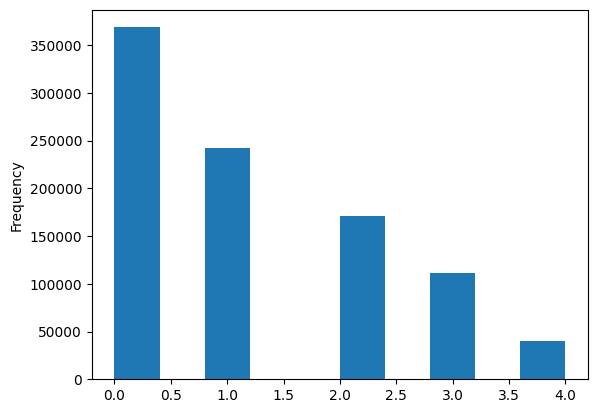

In [ ]:
import pandas as pd
# emo_seq_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/EmotionSequencesWithTargetOutput_PHQ5.csv', sep='\t', index_col=False)

Y_emo_PHQ5_seq = emo_seq_df['PHQ_5'].fillna(-1)
X_emo_PHQ5_seq = emo_seq_df.drop(columns=['File', 'Emotion_num', 'Participant_ID', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity','PHQ_5'])
Y_emo_PHQ5_seq.plot(kind='hist')

In [ ]:
### same as above duplicated but for 0-4 PHQ Score Groups

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_emo_PHQ5_seq, Y_emo_PHQ5_seq, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increased max_iter
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Classifier": MLPClassifier(max_iter=500) # Increased max_iter
}


# Train and evaluate each classifier
for name, clf in classifiers.items():
    try:
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print(f"Classification Report for {name}:")
        print(classification_report(Y_test, Y_pred))
    except Exception as e:
        print(f"Error training {name}: {e}")

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73     52098
           1       0.00      0.00      0.00     16858
           2       0.00      0.00      0.00      9803
           3       0.00      0.00      0.00     10416
           4       0.00      0.00      0.00      1261

    accuracy                           0.58     90436
   macro avg       0.12      0.20      0.15     90436
weighted avg       0.33      0.58      0.42     90436



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     52098
           1       0.65      0.65      0.65     16858
           2       0.63      0.64      0.63      9803
           3       0.59      0.58      0.59     10416
           4       0.50      0.53      0.52      1261

    accuracy                           0.73     90436
   macro avg       0.64      0.64      0.64     90436
weighted avg       0.73      0.73      0.73     90436

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87     52098
           1       0.78      0.69      0.73     16858
           2       0.83      0.65      0.73      9803
           3       0.78      0.60      0.68     10416
           4       0.80      0.51      0.62      1261

    accuracy                           0.81     90436
   macro avg       0.80      0.67      0.73     9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.58      0.97      0.72     52098
           1       0.29      0.02      0.03     16858
           2       0.14      0.03      0.04      9803
           3       0.00      0.00      0.00     10416
           4       0.00      0.00      0.00      1261

    accuracy                           0.56     90436
   macro avg       0.20      0.20      0.16     90436
weighted avg       0.40      0.56      0.43     90436

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     52098
           1       0.74      0.71      0.73     16858
           2       0.77      0.66      0.71      9803
           3       0.75      0.61      0.67     10416
           4       0.73      0.46      0.57      1261

    accuracy                           0.80     90436
   macro avg       0.76      0.67      0.71     90436
weighted avg       0.79      0

In [ ]:

# tmp = pd.DataFrame(consecutive_emotions_df.iloc[0]['Emotion_num_sequence'], columns=['Neutral', 'Happy', 'Sad', 'Angry'])
# df_emo_seq = pd.DataFrame(pd.Series([str(int(consecutive_emotions_df.iloc[0]['File']))]*tmp.shape[0]), columns=['File'])
# df_emo_seq = pd.concat([df_emo_seq, tmp], axis=1)
# df_emo_seq['File'] = df_emo_seq['File'].astype(int)


File    Neutral     Happy       Sad     Angry
0     405  14.187046 -9.379018 -3.045913 -6.609662
1     405  14.284719 -9.366886 -3.174044 -6.572013
2     405  14.304206 -9.403837 -3.065950 -6.716697
3     405  14.288375 -9.383680 -2.933273 -6.866247
4     405  14.171077 -9.548326 -2.768356 -6.757293
...   ...        ...       ...       ...       ...
8717  405   9.443654 -8.029582  1.136672 -6.475491
8718  405   9.411758 -7.947441  1.131248 -6.516442
8719  405   9.451080 -7.895224  1.061950 -6.527257
8720  405   9.498517 -7.906790  1.041877 -6.629751
8721  405   9.487484 -7.947711  1.064885 -6.601189

[8722 rows x 5 columns]

## Preprocessing Prosodic Features Results from Praat

In [ ]:
with open('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/Praat_output_interval_voice_report.csv', 'r') as f:
    lines = f.readlines()

# Now 'lines' is a list where each element is a line from the file
print(lines[0])
print(lines[1:5]) # print first 5 lines to verify


File,Interval Number,Interval Start (s),Interval End (s),Text,Mean Pitch (Hz),Pitch SD (Hz),Mean Intensity (dB),Intensity SD (dB),Jitter (local) (%),Shimmer (local) (%),HNR (dB),Duration (s)

["300_AUDIO.wav,1,14.3,15.1,so I'm going to,254.37333927225922,27.00346766559886,45.37931802368957,4.32289056950293,0.03352245739037268,0.17272158049480965,8.077648956110819,0.7999999999999989\n", '300_AUDIO.wav,2,20.3,21.1, interview in Spanish,229.59877384223063,11.226765540191698,43.783862600290504,5.926899563075884,0.03155637517818635,0.17869875891816178,9.050443731965316,0.8000000000000007\n', '300_AUDIO.wav,3,23.9,24.3, okay,162.66774737309706,39.761161803479936,50.527333896752346,8.632260653876344,0.02171665363506634,0.114560642071033,10.25205967458333,0.40000000000000213\n', '300_AUDIO.wav,4,62.1,62.7, good,158.45797494344427,50.961931229290066,56.2534131116878,7.17724508735505,0.01958337414892487,0.1263891016196256,10.310388965247926,0.6000000000000014\n']


In [ ]:
# tmptxt = lines[1]

In [ ]:
# # prompt: split tmptxt at 4th ','
# split_line_l = tmptxt.split(',', 4)
# print(split_line_l)

# # prompt: split tmptxt at 8th ',' from the back
# split_line_r = tmptxt.rsplit(',', 8) # Split from the right at the 8th comma
# print(split_line_r)

['300_AUDIO.wav', '1', '14.3', '15.1', "so I'm going to,254.37333927225922,27.00346766559886,45.37931802368957,4.32289056950293,0.03352245739037268,0.17272158049480965,8.077648956110819,0.7999999999999989\n"]
["300_AUDIO.wav,1,14.3,15.1,so I'm going to", '254.37333927225922', '27.00346766559886', '45.37931802368957', '4.32289056950293', '0.03352245739037268', '0.17272158049480965', '8.077648956110819', '0.7999999999999989\n']


In [ ]:
line_split = [l.rstrip().split(',') for l in lines]
line_split = [[l[0][:3]] + l[1:]  for l in line_split[1:]]
# line_split[:3]

[['300',
  '1',
  '14.3',
  '15.1',
  "so I'm going to",
  '254.37333927225922',
  '27.00346766559886',
  '45.37931802368957',
  '4.32289056950293',
  '0.03352245739037268',
  '0.17272158049480965',
  '8.077648956110819',
  '0.7999999999999989'],
 ['300',
  '2',
  '20.3',
  '21.1',
  ' interview in Spanish',
  '229.59877384223063',
  '11.226765540191698',
  '43.783862600290504',
  '5.926899563075884',
  '0.03155637517818635',
  '0.17869875891816178',
  '9.050443731965316',
  '0.8000000000000007'],
 ['300',
  '3',
  '23.9',
  '24.3',
  ' okay',
  '162.66774737309706',
  '39.761161803479936',
  '50.527333896752346',
  '8.632260653876344',
  '0.02171665363506634',
  '0.114560642071033',
  '10.25205967458333',
  '0.40000000000000213']]

In [ ]:
def longest_common_substring(str1, str2):
    """
    Finds the longest common substring between two strings.

    Args:
        str1: The first string.
        str2: The second string.

    Returns:
        The longest common substring.
    """
    n = len(str1)
    m = len(str2)

    # Create a table to store lengths of longest common suffixes of substrings.
    # Note: We add an extra row and column for empty prefixes.
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    longest_substring_length = 0
    ending_index = 0

    # Iterate through the strings to fill the dp table.
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > longest_substring_length:
                    longest_substring_length = dp[i][j]
                    ending_index = i

    # Extract the longest common substring from the original strings.
    return str1[ending_index - longest_substring_length:ending_index]


In [ ]:
# lcs = longest_common_substring(split_line_l[-1], split_line_r[0])
# lcs

"so I'm going to"

In [ ]:
# Create a list from the first 5 columns of each row, starting from the second row
data_list = []
for row in line_split:
    data_list.append(row[:4])

# Create a DataFrame from the list
df_acoustic = pd.DataFrame(data_list, columns=lines[0].rstrip().split(',')[:4])

# Create text column
txt = []
for row in lines[1:]:
    split_line_l = row.split(',', 4)
    split_line_r = row.rsplit(',', 8)
    txt.append((longest_common_substring(split_line_l[-1], split_line_r[0])).strip())

df_acoustic[lines[0].rstrip().split(',')[4]] = txt

# Create features column
features = []
for row in line_split:
    features.append(row[-8:])

df_acoustic[lines[0].rstrip().split(',')[5:]] = features
df_acoustic.head()

File Interval Number Interval Start (s) Interval End (s)  \
0  300               1               14.3             15.1   
1  300               2               20.3             21.1   
2  300               3               23.9             24.3   
3  300               4               62.1             62.7   
4  300               5               68.8             69.8   

                   Text     Mean Pitch (Hz)       Pitch SD (Hz)  \
0       so I'm going to  254.37333927225922   27.00346766559886   
1  interview in Spanish  229.59877384223063  11.226765540191698   
2                  okay  162.66774737309706  39.761161803479936   
3                  good  158.45797494344427  50.961931229290066   
4       Atlanta Georgia   148.4111192240321  21.874324624975554   

  Mean Intensity (dB)  Intensity SD (dB)    Jitter (local) (%)  \
0   45.37931802368957   4.32289056950293   0.03352245739037268   
1  43.783862600290504  5.926899563075884   0.03155637517818635   
2  50.527333896752346  8.632260653876344   0.02171665363506634   
3    56.2534131116878   7.17724508735505   0.01958337414892487   
4   53.03539169729283  7.910520535082264  0.022890077509160212   

   Shimmer (local) (%)            HNR (dB)         Duration (s)  
0  0.17272158049480965   8.077648956110819   0.7999999999999989  
1  0.17869875891816178   9.050443731965316   0.8000000000000007  
2    0.114560642071033   10.25205967458333  0.40000000000000213  
3   0.1263891016196256  10.310388965247926   0.6000000000000014  
4  0.10826290425926659  10.813026128424621                    1

In [ ]:
# lines[0].rstrip().split(',')
for c in lines[0].rstrip().split(',')[5:]:
  print(c)
  df_acoustic[c] = df_acoustic[c].replace('--undefined--', -1.0).astype(float)

Mean Pitch (Hz)
Pitch SD (Hz)
Mean Intensity (dB)
Intensity SD (dB)
Jitter (local) (%)
Shimmer (local) (%)
HNR (dB)
Duration (s)


In [ ]:
df_acoustic[lines[0].rstrip().split(',')[5:]].describe()

Mean Pitch (Hz)  Pitch SD (Hz)  Mean Intensity (dB)  Intensity SD (dB)  \
count     25806.000000   25806.000000         25806.000000       25806.000000   
mean        145.089362      24.798811            42.263607           9.662398   
std          45.449316      15.649730             7.195315           3.984183   
min          -1.000000      -1.000000          -123.799877           1.126371   
25%         106.084322      11.808210            38.699861           8.012802   
50%         134.686038      21.828485            42.640218           9.774978   
75%         181.079461      35.395806            46.251439          11.358704   
max         292.298786     133.062613            73.244628         169.499762   

       Jitter (local) (%)  Shimmer (local) (%)      HNR (dB)  Duration (s)  
count        25806.000000         25806.000000  25806.000000  25806.000000  
mean             0.024326             0.109332     11.120731      5.029730  
std              0.046853             0.072878      3.975937      7.119733  
min             -1.000000            -1.000000     -6.634615      0.200000  
25%              0.018448             0.080554      8.444528      1.000000  
50%              0.023456             0.101528     11.306775      2.300000  
75%              0.030571             0.134330     13.817305      5.900000  
max              0.186037             0.740724     35.333356     60.000000

In [ ]:
df_acoustic['Mean Pitch (Hz)'].max()

292.298785753893

<Axes: ylabel='Frequency'>

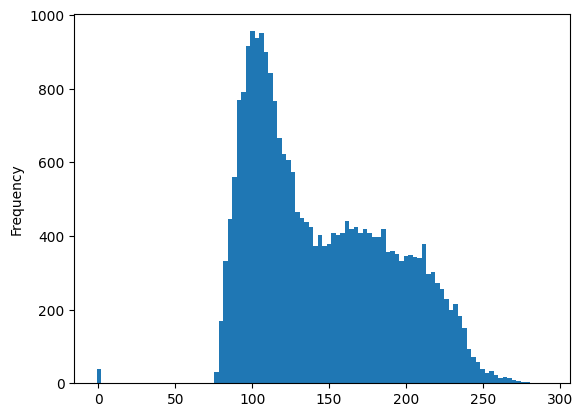

In [ ]:
df_acoustic['Mean Pitch (Hz)'].replace('--undefined--', -1.0).astype(float).plot(kind='hist', bins=100)

In [ ]:
undefined_count = df_acoustic['Mean Pitch (Hz)'].value_counts().get('--undefined--', 0)
print(f"Number of '--undefined--' values in 'Mean Pitch (Hz)': {undefined_count}")

Number of '--undefined--' values in 'Mean Pitch (Hz)': 0


## ------------- Average Emotion -------------

In [ ]:
# emo_flst =  ['300', '301', '302', '303', '304',
#                        '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '415', '416', '417', '418', '419', '420', '421',
#                        '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437',' 438',
#                        '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455',
#                        '456', '457', '458', '459', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473',
#                        '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '485', '484', '486', '487', '488', '489', '490',
#                        '491', '492', '600', '601', '602', '605', '604', '606', '607',
#                        '603', '608', '609' # Causing error in emotion extraciton
#                       ]
emo_flst =            ['300','301','302','303','304','305','306',      '308','309','310','311','312','313','314','315','316','317','318','319',
                       '320','321','322','323','324','325','326','327','328','329','330','331','332','333','334','335','336','337','338','339',
                       '340','341',      '343','344','345','346','347','348','349','350','351','352','353','354','355','356','357','358','359',
                       '360','361','362','363','364','365','366','367','368','369','370','371','372','373','374','375','376','377','378','379',
                       '380','381','382','383','384','385','386','387','388','389','390','391','392','393',      '395','396','397',      '399',
                       '400','401','402','403','404','405','406','407','408','409','410','411','412','413','414','415','416','417','418','419',
                       '420','421','422','423','424','425','426','427','428','429','430','431','432','433','434','435','436','437','438','439',
                       '440','441','442','443','444','445','446','447','448','449','450','451','452','453','454','455','456','457','458','459',
                             '461','462','463','464','465','466','467','468','469','470','471','472','473','474','475','476','477','478','479',
                       '480','481','482','483','485','484','486','487','488','489','490','491','492',
                       '600','601','602','605','604','606','607']

In [ ]:
len(emo_flst)

195

In [ ]:
import json
import re
import numpy as np
import pandas as pd

def parse_string(input_string):
    # Use regex to separate the text and the list of values
    match = re.match(r'^(.+?),"(.*)"$', input_string)
    if not match:
        raise ValueError("Input format is incorrect")

    # Extract text and list part
    text = match.group(1).strip()
    list_str = match.group(2).strip()

    # Parse the list of values from the string format
    try:
        values_list = json.loads(list_str)
    except json.JSONDecodeError:
        raise ValueError("List format is incorrect")

    return text, values_list

def get_avg_emotion(lines, fname):
    txtlst = []
    emolst = []
    for line in lines[2:]:
        text, values_list = parse_string(line)
        txtlst.append(text)
        emolst.append(values_list)

    # import pandas as pd
    df_new = pd.DataFrame({'File': [fname]*len(txtlst),'Text': txtlst, 'Emotion': emolst})
    # print(df_new.head())

    # Calculate the average of each sublist within 'emolst'
    averages = []
    for sublist in emolst:
        try:
            averages.append(np.mean(sublist, axis=0))  # Calculate the mean of each column
        except (TypeError, ValueError):
            averages.append(np.nan)  # Handle cases with invalid data
    # Add averages as new columns to df_new
    if averages:
      df_new[['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry']] = pd.DataFrame(averages, index= df_new.index)
    else:
      print("Error: 'averages' list is empty.")

    # print(df_new.head())

    return df_new, averages

In [ ]:
from google.colab import drive
import pandas as pd
import os

# drive.mount('/content/drive')


directory = '/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/wavNscript/'

df_avr_emo = pd.DataFrame()
for filename in os.listdir(directory):
  if filename.endswith('phrase_emotions.csv'):
    filepath = os.path.join(directory, filename)
    try:
      # df_emo = pd.read_csv(filepath)
      if filename[:3] in emo_flst:
        print(f"Processing file: {filename}")
        with open(filepath, 'r') as f:
          lines = f.readlines()
          df_new, averages = get_avg_emotion(lines, filename[:3])
          df_avr_emo = pd.concat([df_avr_emo, df_new], ignore_index=True)

      # Example: Print the first 5 rows of each file
      # print(df.head())
    except pd.errors.EmptyDataError:
      print(f"Warning: Empty file: {filename}")
    except pd.errors.ParserError:
      print(f"Warning: Error parsing file: {filename}")
    except Exception as e:
      print(f"An error occurred while processing {filename}: {e}")

df_avr_emo

Processing file: 405_phrase_emotions.csv
Processing file: 406_phrase_emotions.csv
Processing file: 404_phrase_emotions.csv
Processing file: 411_phrase_emotions.csv
Processing file: 408_phrase_emotions.csv
Processing file: 407_phrase_emotions.csv
Processing file: 409_phrase_emotions.csv
Processing file: 410_phrase_emotions.csv
Processing file: 414_phrase_emotions.csv
An error occurred while processing 414_phrase_emotions.csv: Input format is incorrect
Processing file: 412_phrase_emotions.csv
Processing file: 416_phrase_emotions.csv
Processing file: 413_phrase_emotions.csv
Processing file: 415_phrase_emotions.csv
Processing file: 421_phrase_emotions.csv
Processing file: 419_phrase_emotions.csv
Processing file: 418_phrase_emotions.csv
Processing file: 420_phrase_emotions.csv
Processing file: 417_phrase_emotions.csv
Processing file: 426_phrase_emotions.csv
Processing file: 424_phrase_emotions.csv
Processing file: 422_phrase_emotions.csv
Processing file: 423_phrase_emotions.csv
Processing f

File                                               Text  \
0      405  essential let you know and then you can let me...   
1      405                                             thanks   
2      405  go ahead and move his cord behind you didn't g...   
3      405                                           hi hello   
4      405                             are you okay with this   
...    ...                                                ...   
17465  403  you know being published I've been on TV shows...   
17466  403  I have a lot of people who read what I ride ev...   
17467  403                    and I work to get to that point   
17468  403                                       great thanks   
17469  403                      computer-related survey about   

                                                 Emotion  avg_Neutral  \
0      [[14.18704605102539, -9.37901782989502, -3.045...    14.325210   
1      [[16.3295955657959, -8.033401489257812, -7.942...    16.111670   
2      [[15.299209594726562, -6.708323001861572, -7.8...    15.490749   
3      [[9.37299633026123, -3.9227797985076904, 1.430...     9.308572   
4      [[9.678568840026855, -11.853007316589355, -6.2...     9.827066   
...                                                  ...          ...   
17465  [[13.04171085357666, -1.9761261940002441, -4.1...    13.211737   
17466  [[8.146602630615234, -2.430422306060791, 0.918...     8.185224   
17467  [[14.606300354003906, 0.45081964135169983, -5....    14.222016   
17468  [[11.528067588806152, -5.588832855224609, 1.04...    11.284095   
17469  [[12.021416664123535, -6.229308128356934, -2.9...    12.212444   

       avg_Happy   avg_Sad  avg_Angry  
0      -9.403361 -3.037173  -6.728367  
1      -7.742381 -7.976411  -4.962175  
2      -6.789825 -8.094583  -4.434079  
3      -4.255228  1.608068 -10.622124  
4     -11.662124 -6.177302   3.665494  
...          ...       ...        ...  
17465  -2.307594 -3.977213  -9.060980  
17466  -2.596524  0.963514  -8.633167  
17467   0.577550 -5.330973 -10.954405  
17468  -5.076588  0.869401 -10.719509  
17469  -6.244126 -3.079093  -6.409406  

[17470 rows x 7 columns]

In [ ]:
# prompt: join df_avr_emo and df_acoustic where File and Text are the same

merged__emo_prosodic_df = pd.merge(df_avr_emo, df_acoustic, left_on=['File', 'Text'], right_on=['File', 'Text'], how='inner')
merged__emo_prosodic_df

File                                               Text  \
0      405  essential let you know and then you can let me...   
1      405                                             thanks   
2      405  go ahead and move his cord behind you didn't g...   
3      405                                           hi hello   
4      405                             are you okay with this   
...    ...                                                ...   
19682  403  Mojo has a magazine and I just wrote years and...   
19683  403  you know being published I've been on TV shows...   
19684  403  I have a lot of people who read what I ride ev...   
19685  403                    and I work to get to that point   
19686  403                                       great thanks   

                                                 Emotion  avg_Neutral  \
0      [[14.18704605102539, -9.37901782989502, -3.045...    14.325210   
1      [[16.3295955657959, -8.033401489257812, -7.942...    16.111670   
2      [[15.299209594726562, -6.708323001861572, -7.8...    15.490749   
3      [[9.37299633026123, -3.9227797985076904, 1.430...     9.308572   
4      [[9.678568840026855, -11.853007316589355, -6.2...     9.827066   
...                                                  ...          ...   
19682  [[8.921466827392578, -3.3850042819976807, 1.04...     9.130574   
19683  [[13.04171085357666, -1.9761261940002441, -4.1...    13.211737   
19684  [[8.146602630615234, -2.430422306060791, 0.918...     8.185224   
19685  [[14.606300354003906, 0.45081964135169983, -5....    14.222016   
19686  [[11.528067588806152, -5.588832855224609, 1.04...    11.284095   

       avg_Happy   avg_Sad  avg_Angry Interval Number Interval Start (s)  \
0      -9.403361 -3.037173  -6.728367               1               18.5   
1      -7.742381 -7.976411  -4.962175               2               23.7   
2      -6.789825 -8.094583  -4.434079               3               26.8   
3      -4.255228  1.608068 -10.622124               4               37.8   
4     -11.662124 -6.177302   3.665494               5                 58   
...          ...       ...        ...             ...                ...   
19682  -3.183801  0.770787  -9.044948              60              769.1   
19683  -2.307594 -3.977213  -9.060980              61              801.8   
19684  -2.596524  0.963514  -8.633167              62              809.2   
19685   0.577550 -5.330973 -10.954405              63              820.1   
19686  -5.076588  0.869401 -10.719509              64              829.5   

      Interval End (s)  Mean Pitch (Hz)  Pitch SD (Hz)  Mean Intensity (dB)  \
0                 22.3       195.833283      27.956319            37.495166   
1                 24.4       213.906198      18.890550            34.553041   
2                 29.9       227.868489      25.753608            35.903733   
3                 38.8       217.838764      55.795004            31.784618   
4                 59.2       215.711843      44.562293            27.765436   
...                ...              ...            ...                  ...   
19682              791       193.974677      25.320507            56.555142   
19683            807.7       195.916859      26.015767            57.739147   
19684            819.2       191.848316      24.493149            57.692490   
19685            821.9       178.186276      34.361868            51.889023   
19686            830.7       191.891676      49.355138            44.139685   

       Intensity SD (dB)  Jitter (local) (%)  Shimmer (local) (%)   HNR (dB)  \
0              10.447007            0.017625             0.075467  17.328332   
1               8.173891            0.054081             0.149123  10.006434   
2               5.361039            0.038445             0.234513   6.314799   
3              10.846122            0.008004             0.039994  19.777981   
4               5.412659            0.023921             0.174085   8.358552   
...   

In [ ]:
merged__emo_prosodic_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/01_Merged_emo_prosodic_df.csv', sep='\t', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-56-bbd805fcddb0>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout() # Adjust layout to prevent labels from overlapping


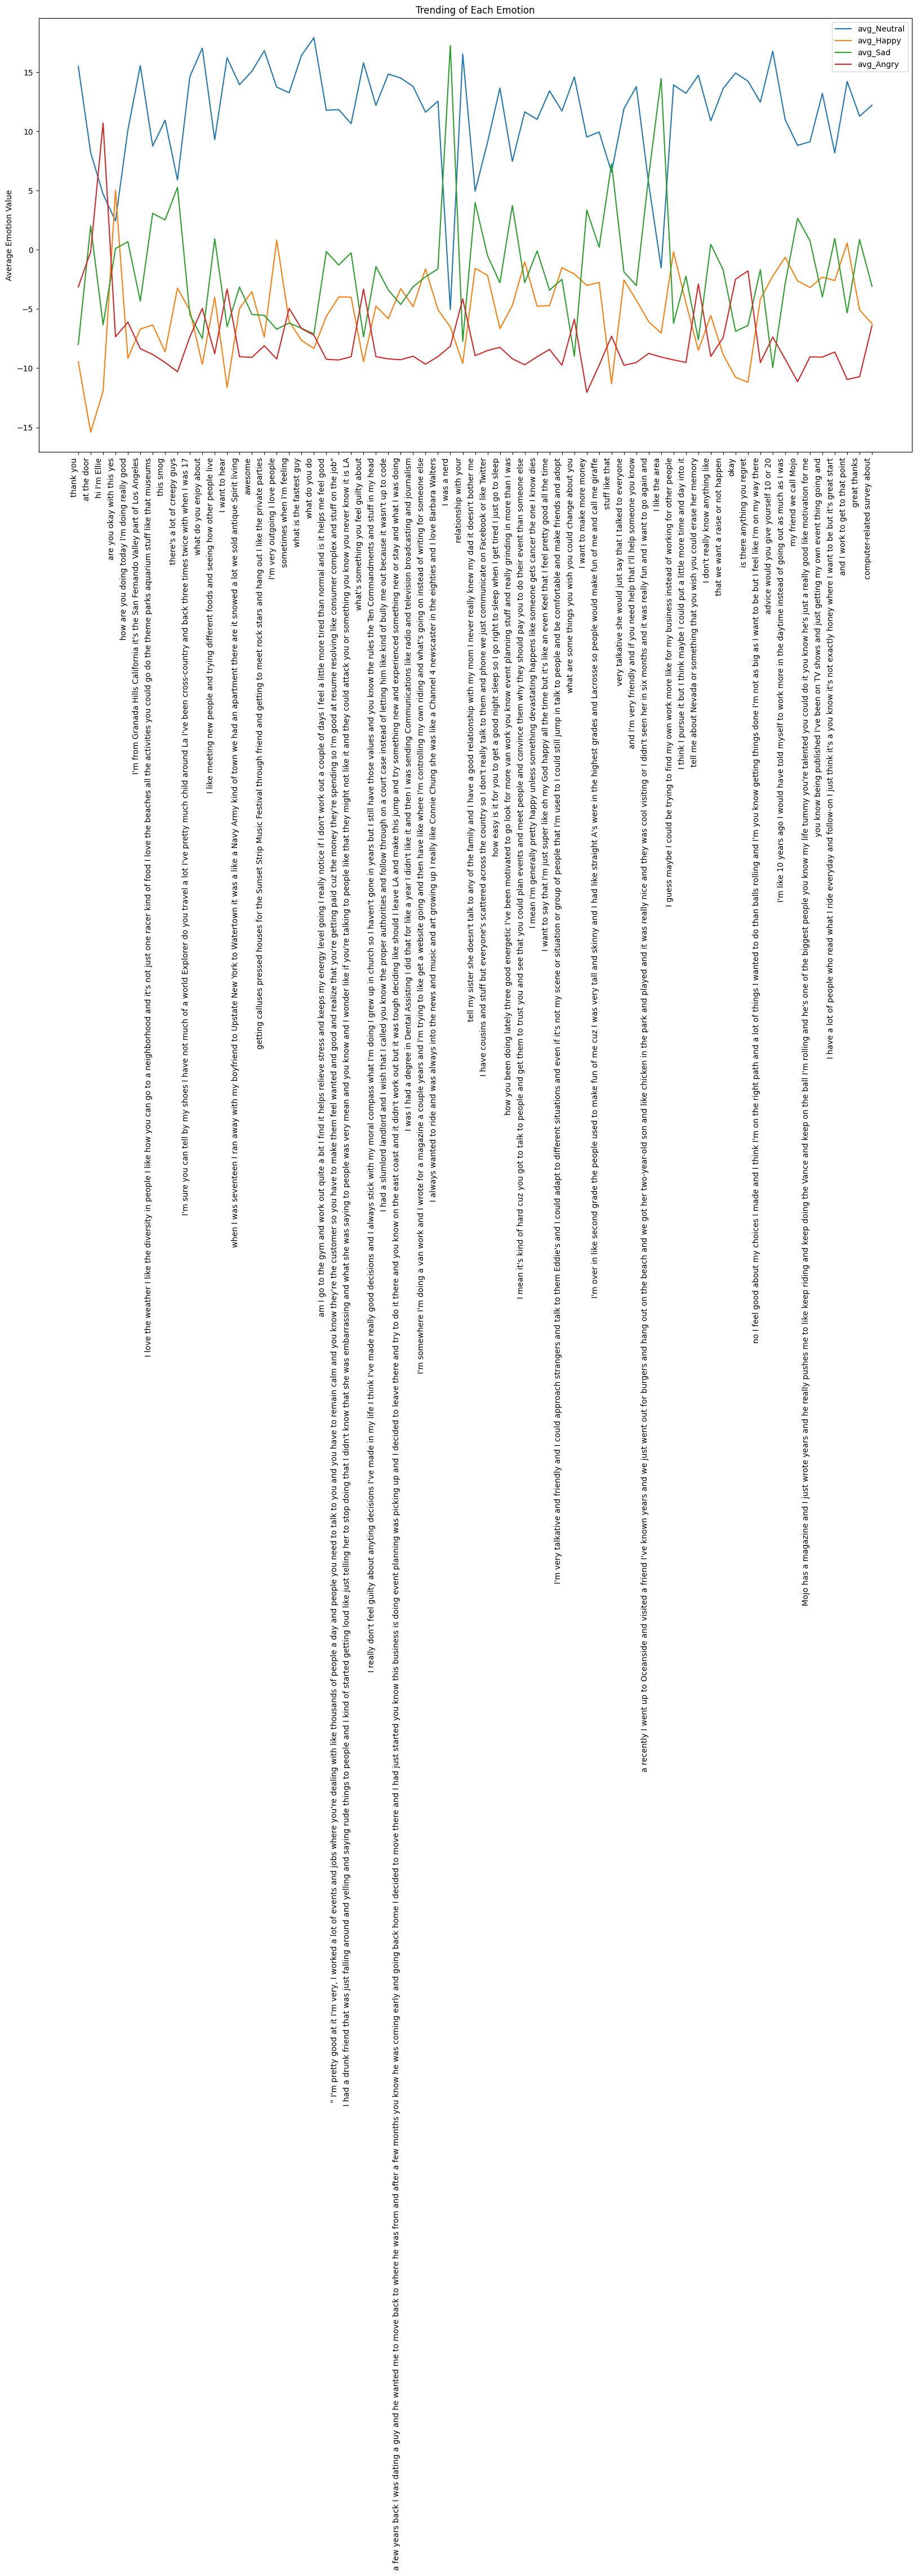

In [ ]:
import matplotlib.pyplot as plt

# Reshape the data for plotting
df_melted = df_new.melt(id_vars=['Text'], value_vars=['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry'], var_name='Emotion', value_name='Value')

# Create the line plot
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
for emotion in df_melted['Emotion'].unique():
  plt.plot(df_melted[df_melted['Emotion'] == emotion]['Text'], df_melted[df_melted['Emotion'] == emotion]['Value'], label=emotion)

plt.ylabel('Average Emotion Value')
plt.title('Trending of Each Emotion')
plt.xticks(rotation=90, ha='right') # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
df_new.describe()

avg_Neutral  avg_Happy    avg_Sad  avg_Angry
count    65.000000  65.000000  65.000000  65.000000
mean     11.599557  -5.259923  -1.829719  -7.667119
std       4.289403   3.587978   5.050636   3.344849
min      -5.047051 -15.398336  -9.947914 -12.043067
25%       9.528727  -7.360757  -5.542117  -9.282960
50%      12.212444  -4.808314  -2.490073  -8.986688
75%      14.508082  -2.761081   0.687546  -7.299287
max      17.918448   5.027099  17.272569  10.716658

In [ ]:
df_target = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/metadata_mapped.csv')

In [ ]:
from matplotlib import pyplot as plt

df_target

Participant_ID AVECParticipant_ID  Gender  PHQ_Binary  PHQ_Score  \
0               302       training_001    male           0          4   
1               303       training_002  female           0          0   
2               304       training_003  female           0          6   
3               305       training_004    male           0          7   
4               307       training_005  female           0          4   
..              ...                ...     ...         ...        ...   
214             667     development_52    male           0          3   
215             670     development_53    male           0          0   
216             687     development_54    male           0          7   
217             698     development_55    male           1         19   
218             713     development_56    male           0          0   

     PCL-C (PTSD)  PTSD Severity  
0               0             28  
1               0             17  
2               0             20  
3               0             28  
4               0             23  
..            ...            ...  
214             0             23  
215             0             21  
216             1             44  
217             1             60  
218             0             22  

[219 rows x 7 columns]

<Figure size 640x480 with 0 Axes>

from matplotlib import pyplot as plt
df_target['Participant_ID'].plot(kind='hist', bins=20, title='Participant_ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Binary'].plot(kind='hist', bins=20, title='PHQ_Binary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Score'].plot(kind='hist', bins=20, title='PHQ_Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['PCL-C (PTSD)'].plot(kind='hist', bins=20, title='PCL-C (PTSD)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_target.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='Participant_ID', y='PHQ_Binary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='PHQ_Binary', y='PHQ_Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='PHQ_Score', y='PCL-C (PTSD)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='PCL-C (PTSD)', y='PTSD Severity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['Participant_ID'].plot(kind='line', figsize=(8, 4), title='Participant_ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Binary'].plot(kind='line', figsize=(8, 4), title='PHQ_Binary')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Score'].plot(kind='line', figsize=(8, 4), title='PHQ_Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_target['PCL-C (PTSD)'].plot(kind='line', figsize=(8, 4), title='PCL-C (PTSD)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='Participant_ID', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='PHQ_Binary', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='PHQ_Score', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='PCL-C (PTSD)', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<Axes: title={'center': 'PHQ_Binary'}, ylabel='Frequency'>

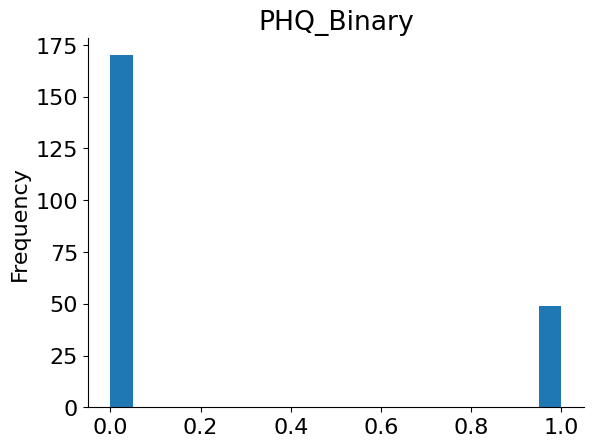

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.rcParams.update({'font.size': 16}) # must set in top
plt.gca().spines[['top', 'right',]].set_visible(False)
df_target['PHQ_Binary'].plot(kind='hist', bins=20, title='PHQ_Binary')
# plt.xlabel('Score')
# plt.ylabel('Frequency')
# plt.show()


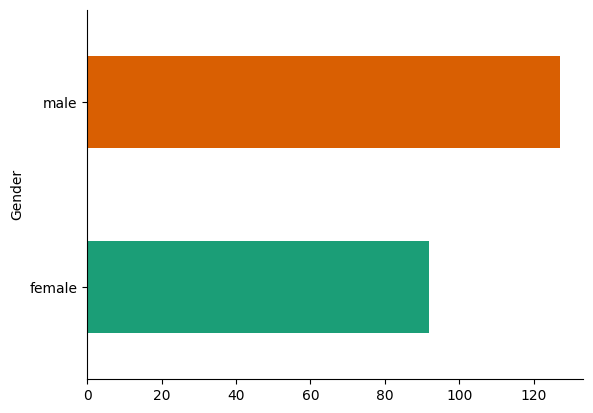

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_target.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_target[['PHQ_Binary','PHQ_Score']].describe()

PHQ_Binary   PHQ_Score
count  219.000000  219.000000
mean     0.223744    6.639269
std      0.417707    6.000192
min      0.000000    0.000000
25%      0.000000    2.000000
50%      0.000000    5.000000
75%      0.000000   10.000000
max      1.000000   23.000000

In [ ]:
# prompt: add columns in df_target to merged__emo_prosodic_df  where merged__emo_prosodic_df['File'] = df_target['Participant_ID']

# Convert 'Participant_ID' to string type to match the 'File' column
df_target['Participant_ID'] = df_target['Participant_ID'].astype(str)
merged__emo_prosodic_df['File'] = merged__emo_prosodic_df['File'].astype(str)

# Iterate through the columns in df_target you want to add
for column in ['PHQ_Binary',	'PHQ_Score',	'PCL-C (PTSD)',	'PTSD Severity']: # Example columns, replace with your desired ones
  # Perform a merge operation
  merged__emo_prosodic_df = pd.merge(merged__emo_prosodic_df,
                                    df_target[['Participant_ID', column]],
                                    left_on='File',
                                    right_on='Participant_ID',
                                    how='left')

  # Drop the redundant 'Participant_ID' column
  merged__emo_prosodic_df = merged__emo_prosodic_df.drop(columns='Participant_ID', errors='ignore')

# Display the updated DataFrame
merged__emo_prosodic_df

File                                               Text  \
0     405  essential let you know and then you can let me...   
1     405                                             thanks   
2     405  go ahead and move his cord behind you didn't g...   
3     405                                           hi hello   
4     405                             are you okay with this   
...   ...                                                ...   
9841  302                                          thank you   
9842  302                                          thank you   
9843  302                                              Bubba   
9844  302                                    why was talking   
9845  302                                          I'm sorry   

                                                Emotion  avg_Neutral  \
0     [[14.18704605102539, -9.37901782989502, -3.045...    14.325210   
1     [[16.3295955657959, -8.033401489257812, -7.942...    16.111670   
2     [[15.299209594726562, -6.708323001861572, -7.8...    15.490749   
3     [[9.37299633026123, -3.9227797985076904, 1.430...     9.308572   
4     [[9.678568840026855, -11.853007316589355, -6.2...     9.827066   
...                                                 ...          ...   
9841  [[9.57912540435791, -11.20682144165039, -7.493...     9.228908   
9842  [[9.57912540435791, -11.20682144165039, -7.493...     9.228908   
9843  [[15.642026901245117, -9.462481498718262, -7.2...    15.622512   
9844  [[10.204808235168457, -13.773117065429688, -5....     9.966529   
9845  [[4.561551570892334, -10.838951110839844, -6.1...     4.573206   

      avg_Happy   avg_Sad  avg_Angry Interval Number Interval Start (s)  \
0     -9.403361 -3.037173  -6.728367               1               18.5   
1     -7.742381 -7.976411  -4.962175               2               23.7   
2     -6.789825 -8.094583  -4.434079               3               26.8   
3     -4.255228  1.608068 -10.622124               4               37.8   
4    -11.662124 -6.177302   3.665494               5                 58   
...         ...       ...        ...             ...                ...   
9841 -11.353075 -7.252645   5.217466              89                650   
9842 -11.353075 -7.252645   5.217466              95              709.8   
9843  -9.524224 -7.229807  -3.879265              96              711.4   
9844 -13.668185 -5.037328   3.627563              97              745.9   
9845 -10.549352 -6.409989   9.173706              98              750.5   

     Interval End (s)  ... Mean Intensity (dB)   Intensity SD (dB)  \
0                22.3  ...   37.49516599696961  10.447006567958502   
1                24.4  ...   34.55304118353577   8.173891320648988   
2                29.9  ...   35.90373258364594   5.361038716451231   
3                38.8  ...  31.784618237775366   10.84612193284636   
4                59.2  ...  27.765435934655358  5.4126586820575655   
...               ...  ...                 ...                 ...   
9841            650.7  ...   43.47650094556729   4.778544593780613   
9842            710.5  ...   42.41527099357123  4.4553498029855465   
9843              712  ...   45.02941556642136   5.796919315429782   
9844            747.1  ...   45.55062024351987   4.747721663214773   
9845            751.1  ...   44.06207185415444   3.025446942317206   

        Jitter (local) (%)  Shimmer (local) (%)            HNR (dB)  \
0     0.017625167353909416  0.07546713756031798  17.328331986245367   
1       0.0540812277196915  0.14912328236456546  10.006433897149893   
2      0.03844460664647801  0.23451321277561868   6.314799021045687   
3     0.008003785407138619  0.03999419780102074   19.77798090019911   
4     0.023921247097675548  0.17408502185901611   8.358552001749787   
...                    ...                  ...                 ...   
9841   0.05187404408990401  0.19607095142868441   4.817835073616229   
9842  0.032093712934932635  0.15219752537773742   2.972136250

In [ ]:
# lines[0].rstrip().split(',')
for c in ['Mean Pitch (Hz)','Pitch SD (Hz)','Mean Intensity (dB)','Intensity SD (dB)','Jitter (local) (%)','Shimmer (local) (%)','HNR (dB)','Duration (s)']:
  print(c)
  merged__emo_prosodic_df[c] = merged__emo_prosodic_df[c].replace('--undefined--', -1.0).astype(float)

Mean Pitch (Hz)
Pitch SD (Hz)
Mean Intensity (dB)
Intensity SD (dB)
Jitter (local) (%)
Shimmer (local) (%)
HNR (dB)
Duration (s)


In [ ]:
merged__emo_prosodic_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/merged__emo_prosodic_df.csv', sep='\t', index=False)

In [ ]:
merged__emo_prosodic_df.columns

Index(['File', 'Text', 'Emotion', 'avg_Neutral', 'avg_Happy', 'avg_Sad',
       'avg_Angry', 'Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)'],
      dtype='object')

In [ ]:
merged__emo_prosodic_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/merged__emo_prosodic_df.csv', sep='\t')
merged__emo_prosodic_df

In [ ]:
# prompt: for each of 'avg_Neutral that have the same 'File' in merged__emo_prosodic_df. Consider them as sequence of values. Get value diff from previous index and store them in column avg_Neutral_pre_diff

# Group by 'File' and then iterate through each group
for file_name, group in merged__emo_prosodic_df.groupby('File'):
    # Calculate the difference between consecutive 'avg_Neutral' values
    # for avg_XXX_pre_diff
    diff_Neutral = group['avg_Neutral'].diff()
    diff_Happy = group['avg_Happy'].diff()
    diff_Sad = group['avg_Sad'].diff()
    diff_Angry = group['avg_Angry'].diff()

    # Store the differences in new columns
    merged__emo_prosodic_df.loc[group.index, 'avg_Neutral_pre_diff'] = diff_Neutral.fillna(0)
    merged__emo_prosodic_df.loc[group.index, 'avg_Happy_pre_diff'] = diff_Happy.fillna(0)
    merged__emo_prosodic_df.loc[group.index, 'avg_Sad_pre_diff'] = diff_Sad.fillna(0)
    merged__emo_prosodic_df.loc[group.index, 'avg_Angry_pre_diff'] = diff_Angry.fillna(0)
    # Modify the difference between consecutive 'avg_Neutral' values
    # for avg_XXX_post_diff
    diff_Neutral.index = diff_Neutral.index - 1
    diff_Happy.index = diff_Happy.index - 1
    diff_Sad.index = diff_Sad.index - 1
    diff_Angry.index = diff_Angry.index - 1

    # Use pd.concat instead of append
    diff_Neutral = pd.concat([diff_Neutral[1:], pd.Series([0], index=[diff_Neutral.index[-1] + 1])])
    diff_Happy = pd.concat([diff_Happy[1:], pd.Series([0], index=[diff_Happy.index[-1] + 1])])
    diff_Sad = pd.concat([diff_Sad[1:], pd.Series([0], index=[diff_Sad.index[-1] + 1])])
    diff_Angry = pd.concat([diff_Angry[1:], pd.Series([0], index=[diff_Angry.index[-1] + 1])])

    # diff_Neutral = diff_Neutral[1:].append(pd.Series([0], index=[diff_Neutral.index[-1] + 1]))
    # diff_Happy = diff_Happy[1:].append(pd.Series([0], index=[diff_Happy.index[-1] + 1]))
    # diff_Sad = diff_Sad[1:].append(pd.Series([0], index=[diff_Sad.index[-1] + 1]))
    # diff_Angry = diff_Angry[1:].append(pd.Series([0], index=[diff_Angry.index[-1] + 1]))


    merged__emo_prosodic_df.loc[group.index, 'avg_Neutral_post_diff'] = diff_Neutral
    merged__emo_prosodic_df.loc[group.index, 'avg_Happy_post_diff'] = diff_Happy
    merged__emo_prosodic_df.loc[group.index, 'avg_Sad_post_diff'] = diff_Sad
    merged__emo_prosodic_df.loc[group.index, 'avg_Angry_post_diff'] = diff_Angry


# Now the 'merged__emo_prosodic_df' DataFrame contains the new 'avg_XXX_pre_diff' column
# also avg_XXX_post_diff

In [ ]:
merged__emo_prosodic_df

File                                               Text  \
0     405.0  essential let you know and then you can let me...   
1     405.0                                             thanks   
2     405.0  go ahead and move his cord behind you didn't g...   
3     405.0                                           hi hello   
4     405.0                             are you okay with this   
...     ...                                                ...   
9841  302.0                                          thank you   
9842  302.0                                          thank you   
9843  302.0                                              Bubba   
9844  302.0                                    why was talking   
9845  302.0                                          I'm sorry   

                                                Emotion  avg_Neutral  \
0     [[14.18704605102539, -9.37901782989502, -3.045...    14.325210   
1     [[16.3295955657959, -8.033401489257812, -7.942...    16.111670   
2     [[15.299209594726562, -6.708323001861572, -7.8...    15.490749   
3     [[9.37299633026123, -3.9227797985076904, 1.430...     9.308572   
4     [[9.678568840026855, -11.853007316589355, -6.2...     9.827066   
...                                                 ...          ...   
9841  [[9.57912540435791, -11.20682144165039, -7.493...     9.228908   
9842  [[9.57912540435791, -11.20682144165039, -7.493...     9.228908   
9843  [[15.642026901245117, -9.462481498718262, -7.2...    15.622512   
9844  [[10.204808235168457, -13.773117065429688, -5....     9.966529   
9845  [[4.561551570892334, -10.838951110839844, -6.1...     4.573206   

      avg_Happy   avg_Sad  avg_Angry Interval Number Interval Start (s)  \
0     -9.403361 -3.037173  -6.728367               1               18.5   
1     -7.742381 -7.976411  -4.962175               2               23.7   
2     -6.789825 -8.094583  -4.434079               3               26.8   
3     -4.255228  1.608068 -10.622124               4               37.8   
4    -11.662124 -6.177302   3.665494               5                 58   
...         ...       ...        ...             ...                ...   
9841 -11.353075 -7.252645   5.217466              89                650   
9842 -11.353075 -7.252645   5.217466              95              709.8   
9843  -9.524224 -7.229807  -3.879265              96              711.4   
9844 -13.668185 -5.037328   3.627563              97              745.9   
9845 -10.549352 -6.409989   9.173706              98              750.5   

     Interval End (s)  ...  PCL-C (PTSD)  PTSD Severity  avg_Neutral_pre_diff  \
0                22.3  ...           1.0           50.0              0.000000   
1                24.4  ...           1.0           50.0              1.786460   
2                29.9  ...           1.0           50.0             -0.620921   
3                38.8  ...           1.0           50.0             -6.182177   
4                59.2  ...           1.0           50.0              0.518494   
...               ...  ...           ...            ...                   ...   
9841            650.7  ...           0.0           28.0             -0.190365   
9842            710.5  ...           0.0           28.0              0.000000   
9843              712  ...           0.0           28.0              6.393604   
9844            747.1  ...           0.0           28.0             -5.655982   
9845            751.1  ...           0.0           28.0             -5.393324   

      avg_Happy_pre_diff  avg_Sad_pre_diff  avg_Angry_pre_diff  \
0               0.000000          0.000000            0.000000   
1               1.660979         -4.939238            1.766192   
2               0.952557         -0.118172            0.528096   
3               2.534596          9.702652           -6.188045   
4              -7.406896         -7.785370           14.287618   
...                  ...               ...                 ...   
9841         

In [ ]:
Y = merged__emo_prosodic_df['PHQ_Binary'].fillna(-1)
X = merged__emo_prosodic_df.drop(columns=['File', 'Text', 'Emotion', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])

In [ ]:
Y.value_counts()

PHQ_Binary
 0.0    7994
 1.0    1242
-1.0     610
Name: count, dtype: int64

In [ ]:
X

avg_Neutral  avg_Happy   avg_Sad  avg_Angry Interval Number  \
0       14.325210  -9.403361 -3.037173  -6.728367               1   
1       16.111670  -7.742381 -7.976411  -4.962175               2   
2       15.490749  -6.789825 -8.094583  -4.434079               3   
3        9.308572  -4.255228  1.608068 -10.622124               4   
4        9.827066 -11.662124 -6.177302   3.665494               5   
...           ...        ...       ...        ...             ...   
9841     9.228908 -11.353075 -7.252645   5.217466              89   
9842     9.228908 -11.353075 -7.252645   5.217466              95   
9843    15.622512  -9.524224 -7.229807  -3.879265              96   
9844     9.966529 -13.668185 -5.037328   3.627563              97   
9845     4.573206 -10.549352 -6.409989   9.173706              98   

     Interval Start (s) Interval End (s)  Mean Pitch (Hz)  Pitch SD (Hz)  \
0                  18.5             22.3       195.833283      27.956319   
1                  23.7             24.4       213.906198      18.890550   
2                  26.8             29.9       227.868489      25.753608   
3                  37.8             38.8       217.838764      55.795004   
4                    58             59.2       215.711843      44.562293   
...                 ...              ...              ...            ...   
9841                650            650.7       102.879093       8.123436   
9842              709.8            710.5        96.743137       8.273773   
9843              711.4              712       164.020503      71.476231   
9844              745.9            747.1        92.318325       6.866355   
9845              750.5            751.1       232.894749      42.443465   

      Mean Intensity (dB)  ...   HNR (dB)  Duration (s)  avg_Neutral_pre_diff  \
0               37.495166  ...  17.328332           3.8              0.000000   
1               34.553041  ...  10.006434           0.7              1.786460   
2               35.903733  ...   6.314799           3.1             -0.620921   
3               31.784618  ...  19.777981           1.0             -6.182177   
4               27.765436  ...   8.358552           1.2              0.518494   
...                   ...  ...        ...           ...                   ...   
9841            43.476501  ...   4.817835           0.7             -0.190365   
9842            42.415271  ...   2.972136           0.7              0.000000   
9843            45.029416  ...   4.760564           0.6              6.393604   
9844            45.550620  ...   2.719357           1.2             -5.655982   
9845            44.062072  ...   5.874607           0.6             -5.393324   

      avg_Happy_pre_diff  avg_Sad_pre_diff  avg_Angry_pre_diff  \
0               0.000000          0.000000            0.000000   
1               1.660979         -4.939238            1.766192   
2               0.952557         -0.118172            0.528096   
3               2.534596          9.702652           -6.188045   
4              -7.406896         -7.785370           14.287618   
...                  ...               ...                 ...   
9841            1.886379        -10.331124           10.377768   
9842            0.000000          0.000000            0.000000   
9843            1.828851          0.022838           -9.096731   
9844           -4.143962          2.192479            7.506828   
9845            3.118834         -1.372662            5.546143   

      avg_Neutral_post_diff  avg_Happy_post_diff  avg_Sad_post_diff  \
0                  1.786460             1.660979          -4.939238   
1                 -0.620921             0.952557          -0.118172   
2                 -6.182177             2.534596           9.702652   
3                  0.518494            -7.406896          -7.785370   
4                -10.547027            33.873614          -0.721482   
...                     ...                  ...                ...   
9

In [ ]:
# prompt: How to use all possible sklearn Classifier to predict Y from X

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Assuming X and Y are already defined as in your provided code.
# Replace 'your_target_variable' with the actual name of your target variable column

# Handle missing values (replace with your preferred strategy)
X = X.fillna(0)  # Example: Fill with zeros
# Or use imputation:
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(strategy='mean')
# X = imp.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000), # Increased max_iter
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis()
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    try:
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(Y_test, y_pred)
        results[name] = accuracy
        print(f"{name}: Accuracy = {accuracy}")
    except Exception as e:
        print(f"Error training {name}: {e}")

print("\nOverall Results:")
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy}")

RandomForest: Accuracy = 0.8467005076142132


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost: Accuracy = 0.8060913705583757
GradientBoosting: Accuracy = 0.8421319796954315
DecisionTree: Accuracy = 0.7609137055837564


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression: Accuracy = 0.8121827411167513
SVM: Accuracy = 0.8131979695431472
KNN: Accuracy = 0.817258883248731
NaiveBayes: Accuracy = 0.6974619289340102
LinearDiscriminantAnalysis: Accuracy = 0.8126903553299493
QuadraticDiscriminantAnalysis: Accuracy = 0.6725888324873096

Overall Results:
RandomForest: Accuracy = 0.8467005076142132
AdaBoost: Accuracy = 0.8060913705583757
GradientBoosting: Accuracy = 0.8421319796954315
DecisionTree: Accuracy = 0.7609137055837564
LogisticRegression: Accuracy = 0.8121827411167513
SVM: Accuracy = 0.8131979695431472
KNN: Accuracy = 0.817258883248731
NaiveBayes: Accuracy = 0.6974619289340102
LinearDiscriminantAnalysis: Accuracy = 0.8126903553299493
QuadraticDiscriminantAnalysis: Accuracy = 0.6725888324873096


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
import seaborn as sns
sns.pairplot(merged__emo_prosodic_df)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

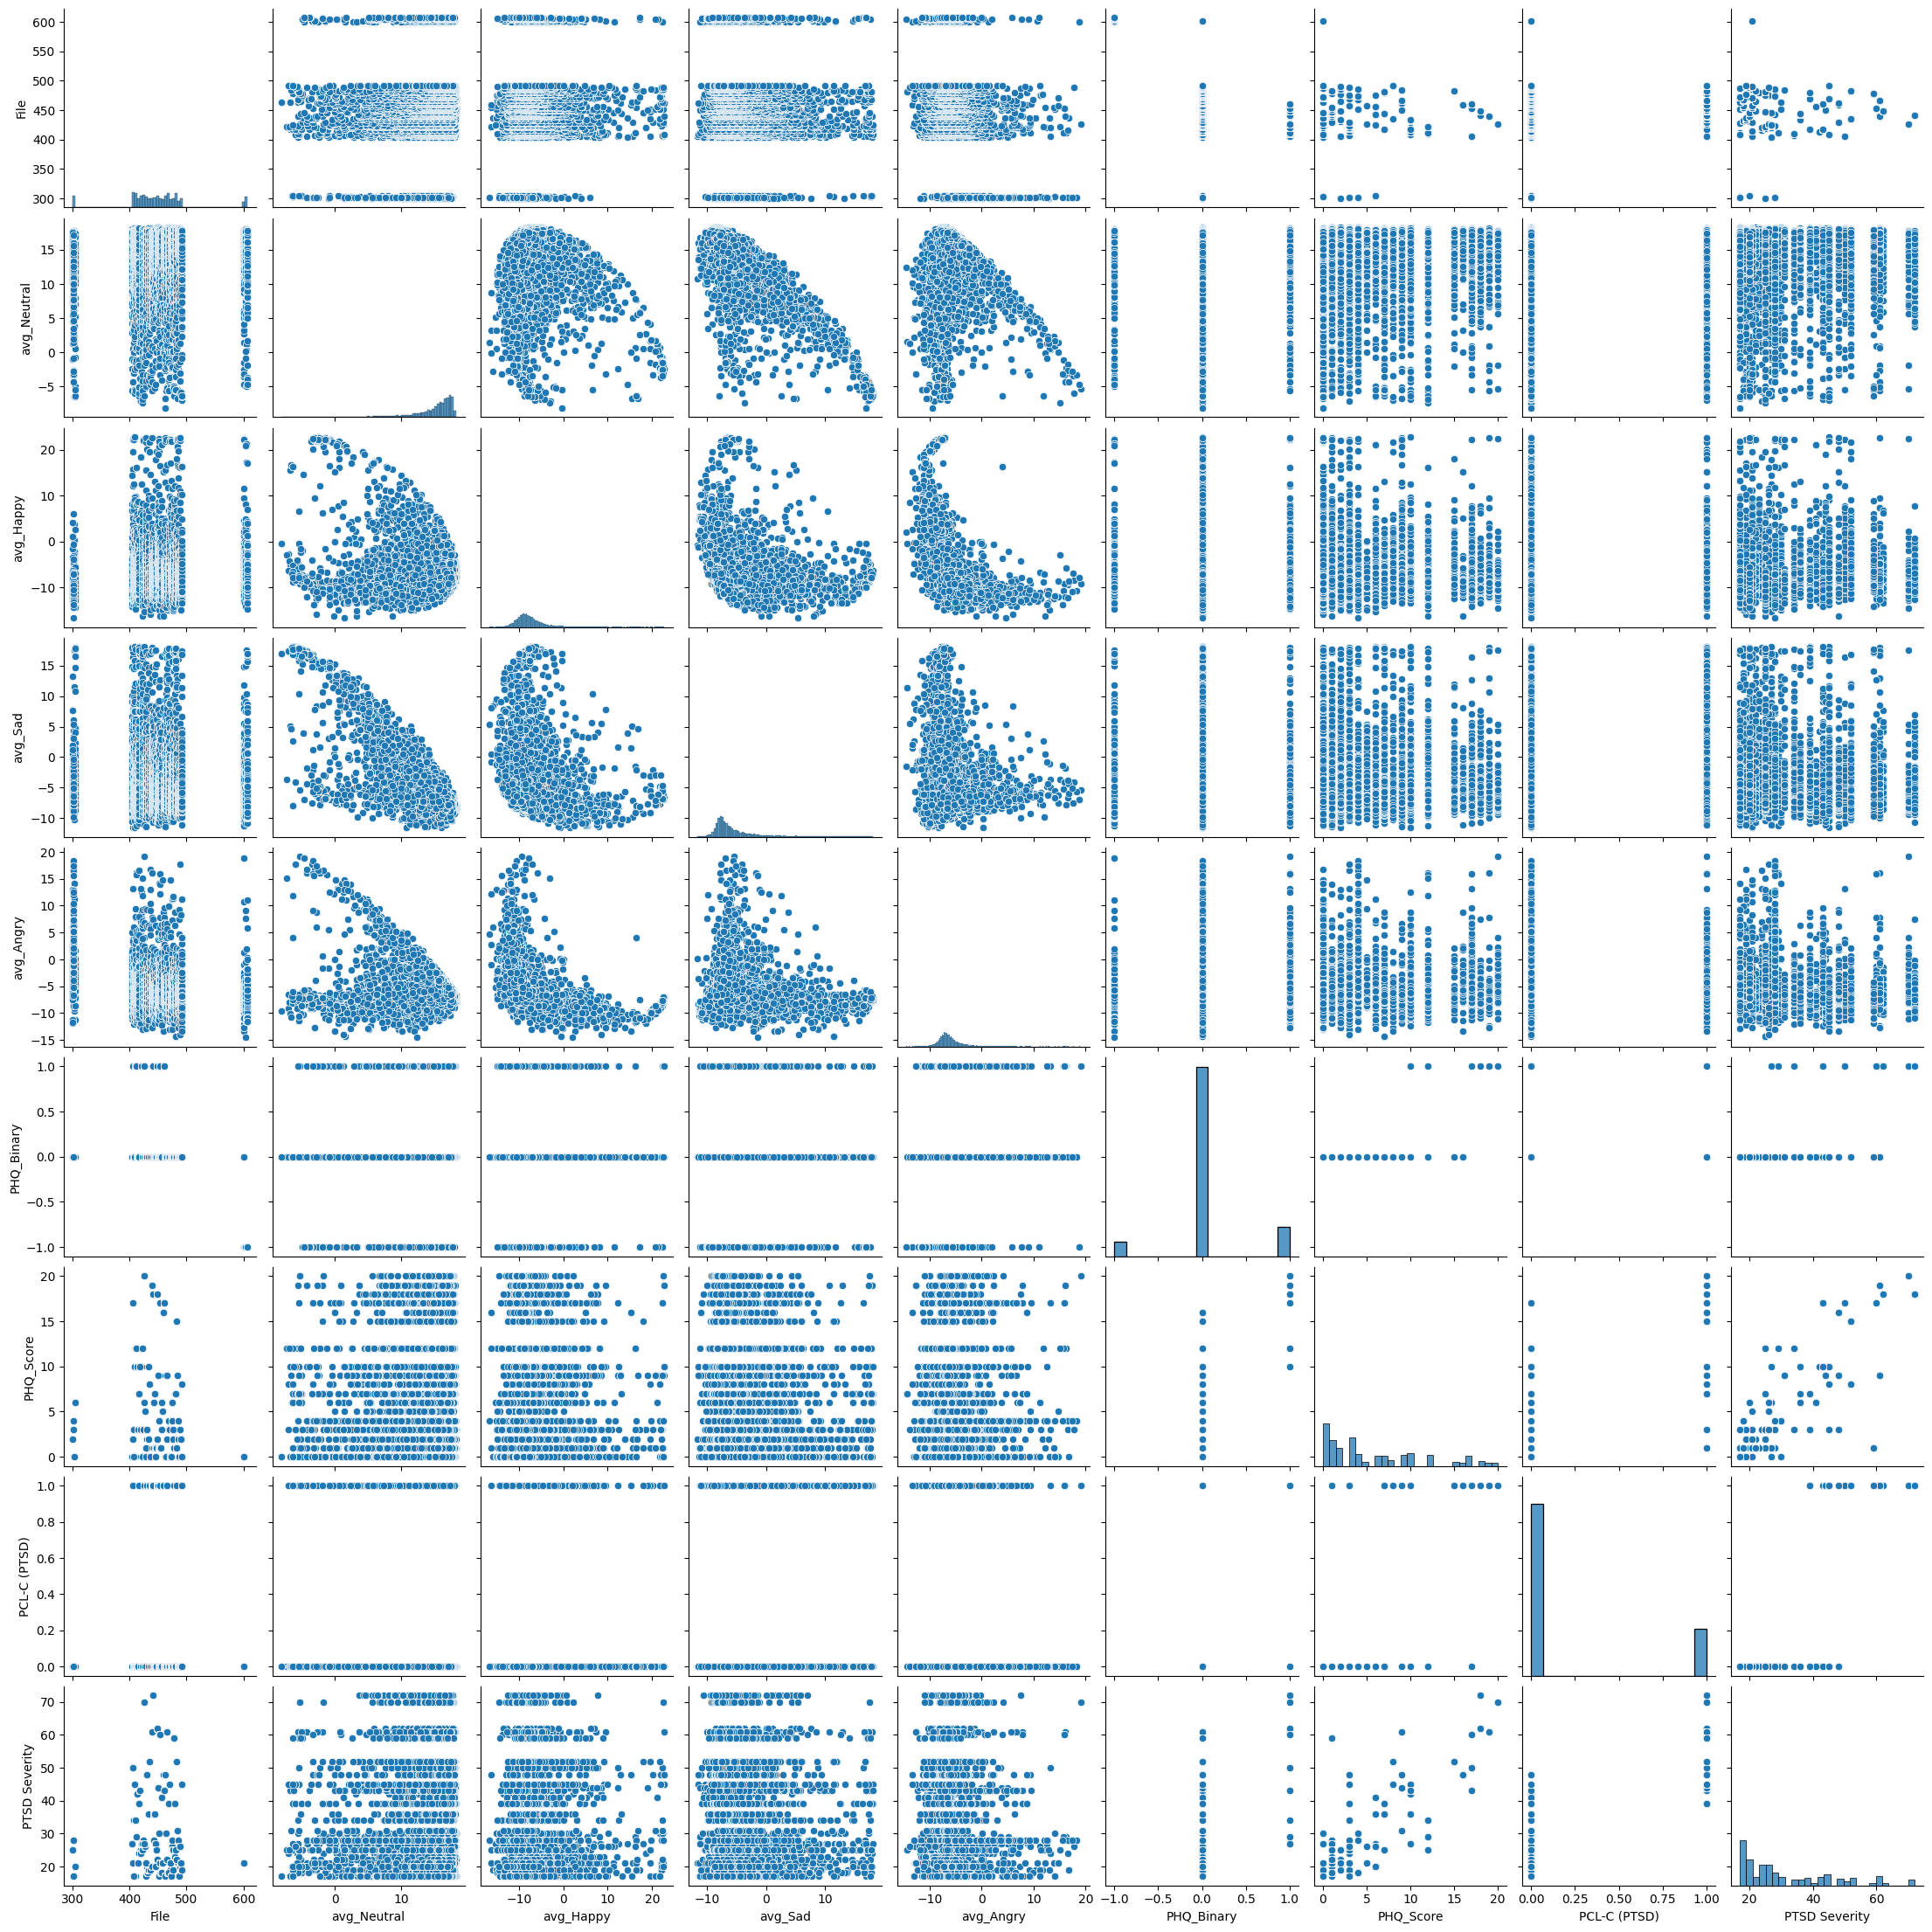

In [ ]:
sns.pairplot(merged__emo_prosodic_df[['File','avg_Neutral', 'avg_Happy', 'avg_Sad',
       'avg_Angry', 'PHQ_Binary',
       'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity']])
plt.show()

In [ ]:
sns.pairplot(merged__emo_prosodic_df[['File', 'Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)', 'PHQ_Binary',
       'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity']])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Y_Score = merged__emo_prosodic_df['PHQ_Score'].fillna(-1)

<Axes: ylabel='Frequency'>

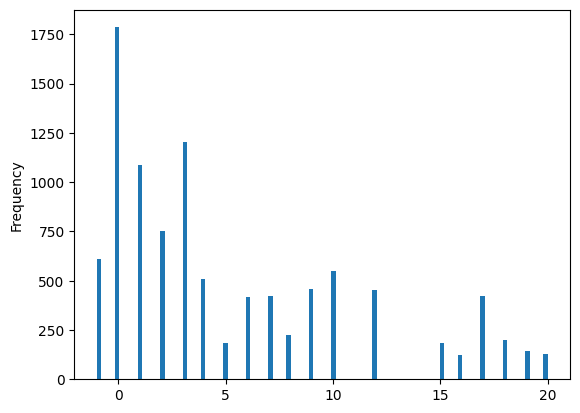

In [ ]:
Y_Score.plot(kind='hist', bins=100)

In [ ]:
# prompt: How to use all possible sklearn Regressor to predict Y_Score from X

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# ... (Your existing code) ...

Y_Score = merged__emo_prosodic_df['PHQ_Score'].fillna(-1)
X = merged__emo_prosodic_df.drop(columns=['File', 'Text', 'Emotion', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])
X = X.fillna(0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_Score, test_size=0.2, random_state=42)

regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(),
    "SVR": SVR(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42)
}

results = {}
for name, reg in regressors.items():
    try:
        reg.fit(X_train, Y_train)
        y_pred = reg.predict(X_test)
        mae = mean_absolute_error(Y_test, y_pred)
        r2 = r2_score(Y_test, y_pred)
        results[name] = {'mae': mae, 'r2': r2}
        print(f"{name}: MAE = {mae}, R^2 = {r2}")
    except Exception as e:
        print(f"Error training {name}: {e}")

print("\nOverall Regression Results:")
for name, metrics in results.items():
    print(f"{name}: MAE = {metrics['mae']}, R^2 = {metrics['r2']}")

LinearRegression: MAE = 4.496968254618543, R^2 = 0.0784855289343801
Ridge: MAE = 4.49712601081704, R^2 = 0.07875674520387577
Lasso: MAE = 4.5449409312988065, R^2 = 0.07195949872531904
ElasticNet: MAE = 4.531208343062827, R^2 = 0.07436716855492598
SGDRegressor: MAE = 39618366793622.22, R^2 = -5.525246695465582e+25
SVR: MAE = 4.187694642605421, R^2 = -0.01022603293527835
KNeighborsRegressor: MAE = 4.261116751269037, R^2 = 0.0402736704804767
DecisionTreeRegressor: MAE = 4.387309644670051, R^2 = -0.3565718607465811
RandomForestRegressor: MAE = 3.626573604060914, R^2 = 0.3334441029775863
AdaBoostRegressor: MAE = 4.635703448506585, R^2 = 0.10008664018800872
GradientBoostingRegressor: MAE = 4.126509392404044, R^2 = 0.20883674600043445

Overall Regression Results:
LinearRegression: MAE = 4.496968254618543, R^2 = 0.0784855289343801
Ridge: MAE = 4.49712601081704, R^2 = 0.07875674520387577
Lasso: MAE = 4.5449409312988065, R^2 = 0.07195949872531904
ElasticNet: MAE = 4.531208343062827, R^2 = 0.0743

In [ ]:
merged__emo_prosodic_df[['avg_Happy', 'avg_Sad', 'avg_Angry', 'avg_Neurtal']]

File                                               Text  \
0     405.0  essential let you know and then you can let me...   
1     405.0                                             thanks   
2     405.0  go ahead and move his cord behind you didn't g...   
3     405.0                                           hi hello   
4     405.0                             are you okay with this   
...     ...                                                ...   
9841  302.0                                          thank you   
9842  302.0                                          thank you   
9843  302.0                                              Bubba   
9844  302.0                                    why was talking   
9845  302.0                                          I'm sorry   

                                                Emotion  avg_Neutral  \
0     [[14.18704605102539, -9.37901782989502, -3.045...    14.325210   
1     [[16.3295955657959, -8.033401489257812, -7.942...    16.111670   
2     [[15.299209594726562, -6.708323001861572, -7.8...    15.490749   
3     [[9.37299633026123, -3.9227797985076904, 1.430...     9.308572   
4     [[9.678568840026855, -11.853007316589355, -6.2...     9.827066   
...                                                 ...          ...   
9841  [[9.57912540435791, -11.20682144165039, -7.493...     9.228908   
9842  [[9.57912540435791, -11.20682144165039, -7.493...     9.228908   
9843  [[15.642026901245117, -9.462481498718262, -7.2...    15.622512   
9844  [[10.204808235168457, -13.773117065429688, -5....     9.966529   
9845  [[4.561551570892334, -10.838951110839844, -6.1...     4.573206   

      avg_Happy   avg_Sad  avg_Angry Interval Number Interval Start (s)  \
0     -9.403361 -3.037173  -6.728367               1               18.5   
1     -7.742381 -7.976411  -4.962175               2               23.7   
2     -6.789825 -8.094583  -4.434079               3               26.8   
3     -4.255228  1.608068 -10.622124               4               37.8   
4    -11.662124 -6.177302   3.665494               5                 58   
...         ...       ...        ...             ...                ...   
9841 -11.353075 -7.252645   5.217466              89                650   
9842 -11.353075 -7.252645   5.217466              95              709.8   
9843  -9.524224 -7.229807  -3.879265              96              711.4   
9844 -13.668185 -5.037328   3.627563              97              745.9   
9845 -10.549352 -6.409989   9.173706              98              750.5   

     Interval End (s)  ...  Mean Intensity (dB)  Intensity SD (dB)  \
0                22.3  ...            37.495166          10.447007   
1                24.4  ...            34.553041           8.173891   
2                29.9  ...            35.903733           5.361039   
3                38.8  ...            31.784618          10.846122   
4                59.2  ...            27.765436           5.412659   
...               ...  ...                  ...                ...   
9841            650.7  ...            43.476501           4.778545   
9842            710.5  ...            42.415271           4.455350   
9843              712  ...            45.029416           5.796919   
9844            747.1  ...            45.550620           4.747722   
9845            751.1  ...            44.062072           3.025447   

      Jitter (local) (%)  Shimmer (local) (%)   HNR (dB)  Duration (s)  \
0               0.017625             0.075467  17.328332           3.8   
1               0.054081             0.149123  10.006434           0.7   
2               0.038445             0.234513   6.314799           3.1   
3               0.008004             0.039994  19.777981           1.0   
4               0.023921             0.174085   8.358552           1.2   
...                  ...                  ...        ...           ...   
9841            0.051874             0.196071   4.817835           0.7   
9842           

# Tmp


### Report draft

Here’s a compact research timeline broken down into four weeks, focusing on key tasks for your project:

### Research Timeline

#### Week 1: Data Acquisition and Familiarization
- **Task 1**: Obtain the Extended Distress Analysis Interview Corpus (E-DAIC) from the University of Southern California.
- **Task 2**: Review the dataset to understand its structure, features, and potential challenges.
- **Task 3**: Familiarize yourself with SpeechBrain and Praat software for speech recognition and feature extraction.

#### Week 2: Feature Extraction and Preliminary Analysis
- **Task 1**: Extract prosodic features from the audio recordings using Praat.
- **Task 2**: Analyze the extracted features to identify patterns and correlations with depression severity.
- **Task 3**: Begin the literature review on related works in speech analysis and depression detection.

#### Week 3: Model Development and Training
- **Task 1**: Create a multimodal input by combining extracted features with ASR transcriptions and emotion embeddings from SpeechBrain.
- **Task 2**: Develop the transformer-based depression classifier and define output depression classes based on PHQ-8 scores.
- **Task 3**: Train the model using the training set and optimize hyperparameters through cross-validation.

#### Week 4: Evaluation and Documentation
- **Task 1**: Evaluate the model on the test set of the E-DAIC corpus using RMSE and other performance metrics.
- **Task 2**: Compile findings and insights from the analysis and model evaluation.
- **Task 3**: Write and finalize the research proposal, including all sections, references, and acknowledgments.

---

This timeline organizes your research tasks into manageable weekly segments, helping you stay focused and on track throughout the project. Feel free to adjust any tasks or timeframes as needed!

In [ ]:
import scipy

scipy.io.wavfile.write("techno.wav", rate=model.config.sampling_rate, data=waveform.numpy())

In [ ]:
from IPython.display import Audio

Audio(waveform, rate=model.config.sampling_rate)